<a id="top"></a>
# Анализ оттока клиентов банка «Метанпром»

Заказщик: менеджер отдела маркетинга банка «Метанпром» <br>
___
Доменная область: «Банки» <br>
Проект: Анализ оттока клиентов<br>
[**Презинтация**](https://disk.yandex.ru/i/V8DSw_OYsKgSNQ)
___

<a id="introduction"></a>
## [Введение](#description)

Банк "Метанпром" имеет отток клиентов. Необходимо выявить и описать характеристики отточных клиентов. На основе выявленных характеристик сформировать не менее трёх сегментов с оттоком превышающим средний по банку в 2 раза и более. Описать сегменты и предложить рекомендации по их удержанию.

<a id="description"></a>
### [Описание проекта](#top)

Проект состоит из следующих этапов:
1. [Введение](#introduction)
    * 1.1 [Описание проекта](#description)
    * 1.2 [Исходные данные](#source_data)
    * 1.3 [Библиотеки и функции](#libraries)
    * 1.4 [Загрузка данных](#loading)
    <p></p>
2. [Обзор и предобработка данных](#overview)
    * 2.1 [Обзор](#review)
    * 2.2 [Предобработка](#preprocessing)
    * 2.3 [Итоговый обзор](#final_overview)
    <p></p>
3. [Исследование](#research)
    * 3.1 [Общий отток](#churn)
    * 3.2 [Обобщённый портрет](#general_view)
    * 3.3 [Исследование характеристик](#find_features)
        * 3.3.1  [Рейтинг](#find_score)
        * 3.3.2  [Возраст](#find_age)
        * 3.3.3  [Баланс на счёте](#find_balance)
        * 3.3.4  [Оценочный доход](#find_est_salary)
        * 3.3.5  [Город](#find_city)
        * 3.3.6  [Пол клиента](#find_gender)
        * 3.3.7  [Ликвидность собстенности](#find_equity)
        * 3.3.8  [Количество продуктов](#find_products)
        * 3.3.9  [Наличие кредитной карты](#find_credit_card)
        * 3.3.10 [Активность клиента](#find_last_activity)
        * 3.3.11 [Корреляция](#find_corr)
    * 3.4 [Статистические гипотезы](#hypothesis)
    * 3.5 [Итоги исследования](#research_overview)
    <p></p>
4. [Формирование сегментов](#signatures)
5. [Итоги проекта](#оverall_conclusion)

Вначале проведём обзор и предобработку предоставленных данных. Затем исследуем характеристики клиентов по признаку оттока. Скомбинируем признаки для формирования высокоотточных сегментов. В конце подведём итоги и предоставим рекомендации. Презентация проекта исследования представлена под заголовком названия.

<a id="source_data"></a>
### [Исходные данные](#description)

Датасет bank_scrooge.csv содержит следующие поля:

Параметры клиента:
- `USERID ` — уникальный идентификатор пользователя, присваеваемый банком. Номера могут быть присвоены повторно, но другим персонам;
- `gender` — пол клиента (категория, бинарная дискретная величина):
    - М - мужской,
    - Ж - женский;
- `age` — возраст клиента (непрерывная величина);
- `city ` — город (категория, кодирование в бинарную величну):
    - Ростов,
    - Ярославль,
    - Рыбинск;
- `products` — количество продуктов (0 - 5), которыми пользуеться клиент (дискретная величина);

Параметры финансового состояния клиента:
- `score ` — баллы кредитного скоринга (максимум 1000) (заявлена как "непрерывная" величина);
- `equity` — количество баллов собственности (от 0 - 9) (дискретная величина);
- `balance` — баланс на счёте (заявлена как непрерывная величина);
- `EST_SALARY` — оценочный доход клиента (заявлена как непрерывная величина);

Признаки:
- `credit_card` — есть ли кредитная карта (бинарная дискретная величина):
    - 0 - нет,
    - 1 - есть;
- `last_activity` — активный клиент (бинарная дискретная величина):
    - 0 - нет,
    - 1 - да;
- `churn` — признак оттока (бинарная дискретная величина):
    - 0 - нет,
    - 1 - да.
    
*_в ходе работы названия колонок могут быть изменены и добавлены новые колонки с производными данными на основе исходных; типы исходных данных могут быть оптимизированны без потерь._

<a id="libraries"></a>
### [Библиотеки и функции](#description)
В исследовании используются следующие библиотеки, настройки и функции.

**Библиотеки и настройки**

В работе используются следующте библиотеки и настройки:

In [1]:
#-----------------------------------------------------DataFrame & Array
import pandas as pd
import numpy as np
#-----------------------------------------------------Visual Output 
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
#-----------------------------------------------------Science
import phik
from scipy import stats as st
import statsmodels.api as sm
from scipy.stats import kstest
#-----------------------------------------------------Additional
import os
#-----------------------------------------------------Options
pd.options.display.max_colwidth = 1 #во всю ширину

**Функции**

В работе используются следующие функции:

In [2]:
def about_data(data, df_columns_list = [], limits = 'yes', limit_rows = 100000, limit_columns = 50, extension = False): 
    """
    V 1.1
    """
#-------------------------------------------------------------------------------------------------Коррекция входных параметров
    ##------------------------------------------------------------------------------------------------Проверка типа передачи колонок
    if type(df_columns_list) != list:
        df_columns_list = [df_columns_list]
        print('⚠️ Warning. The type of inputs at the field "df_columns_list" should be "list".✅ Input value is converted to list now.')
    ##------------------------------------------------------------------------------------------------Проверка корректности ввода limits
    limits = limits.lower()
    if limits == 'y':
        limits = 'yes'
    elif limits == 'n':
        limits = 'no'
    elif limits == 'r':
        limits = 'rows'
    elif limits == 'c':
        limits = 'columns'
    elif limits == 'rows' or limits == 'columns' or limits == 'yes' or limits == 'no':
        pass
    else:
        limits = 'yes'
        print('❌ Error. Incorrect input in the field "limits".✅ Setting set to default.')
    ##------------------------------------------------------------------------------------------------Проверка типа и размеров ограничителей строк/столбцов 
    try:
        limit_rows = round(limit_rows)
    except:
        print('❌ Error. Incorrect input in the field "limit_rows" (must be type "integer").✅ Setting set to default.')
        limit_rows = 100000 
    try:
        limit_columns = round(limit_columns)
    except: 
        print('❌ Error. Incorrect input in the field "limit_columns" (must be type "integer").✅ Setting set to default.')
        limit_columns = 50
    ###-----------------------------------------------------------------------------------------------Проверка корректности установки limits в зависимости от размеров ограничителей
    if limit_rows == 0 and limit_columns != 0:
        limits = 'columns'
    elif limit_rows != 0 and limit_columns == 0:
        limits = 'rows'
    elif limit_rows == 0 and limit_columns == 0:
        limits = 'no'
        print('⚠️ Warning. Column and row limits are set: "0". ✅ The limits setting set to "No".')
#-------------------------------------------------------------------------------------------------Оценка переданных данных
    ##---------------Результаты обобщения
    name_columns = []
    nan_info = []
    dupls = []
    nuniq = []
    total_row = True
##---------------------------------------------------------------------------------------------Обработка и оценка в соотвествии с типом
    if str(type(data)) == "<class 'pandas.core.frame.DataFrame'>":
        print('➡️ Entered data type: DataFrame')
        
        if len(df_columns_list) > 0:
            checked_columns_list = []
            for i, name in enumerate(df_columns_list):
                if name in data.columns:
                    checked_columns_list.append(name)
                else:
                    print(f"❌ Error. The column '{name}' at position {i+1} is not part of entered DataFrame. ✅ Column was ignored.")
            if len(checked_columns_list) == 0:
                checked_columns_list = data.columns
                print("⚠️ Warning. All entered columns was ignored. ✅ All available columns will be used.")
            data = data[checked_columns_list]
            if len(df_columns_list) == 1:
                total_row = False
            else:
                total_row = True   
                
        rows_size, columns_size = data.shape 

        if (limits == 'yes' or limits == 'rows') and rows_size > limit_rows:

            data = data.loc[data.index[:limit_rows]]
            print(f'✅ Row limit set: {limit_rows}')
            
        if (limits == 'yes' or limits == 'columns') and columns_size > limit_columns:
            data = data[data.columns[:limit_columns]]
            print(f'✅ Сolumn limit set: {limit_columns}')

        for column_name in data.columns:
            name_columns.append(column_name)
            nan_info.append(data[column_name].isna().sum())
            dupls.append(data[data[column_name].isna() == False][column_name].duplicated().sum())
            nuniq.append(data[column_name].nunique())
            
        cells = (data.shape[0]*data.shape[1])
        
        if extension:
            try:
                about_data_visual_extention(data, df_columns_list = [], limits = limits, limit_rows = limit_rows, limit_columns = limit_columns)
            except:
                print("❌ Error. Visual extention is not available")
                
    elif str(type(data)) == "<class 'pandas.core.series.Series'>":

        print('➡️ Entered data type: Series')
        if len(df_columns_list) > 0: 
            print("❌ Error. Series don't have columns. ✅ Field 'df_columns_list' was passed.")
            
        if (limits == 'yes' or limits == 'rows') and len(data) > limit_rows:
            data = data.loc[data.index[:limit_rows]]  
            print(f'✅ Row limit set: {limit_rows}')
          
        nan_info = data.isna().sum()
        name_columns.append('Series')
        dupls.append(data[data.isna() == False].duplicated().sum())
        nuniq.append(data.nunique())
        cells = data.shape[0]
        total_row = False
        
        if extension:
            try:
                about_data_visual_extention(data, df_columns_list = [], limits = limits, limit_rows = limit_rows, limit_columns = limit_columns)
            except:
                print("❌ Error. Visual extention is not available")
                
    elif data == "author":
        return print('➡️ Hi there! I wrote this code to help people do data analysis. Together we can achieve more!\n✅ Want to help or discuss? My github:','https://github.com/Linecore')
    
    else: #For Other Types of Data Storage
        return print('❌ Error. Incorrect type of data entered. Pandas Dataframe or Series only for now')
#----------------------------------------------------------------------------------------------------------Сбор обобщённой информации в фрейм для вывода      
    info_df = pd.DataFrame(data = nan_info, index = name_columns, columns = ['total_nan'])
    info_df['%_nan'] = round((info_df['total_nan'] / data.shape[0])*100,2)
    info_df['duplicated'] = dupls
    info_df['nunique'] = nuniq
    info_df['non_null'] = data.shape[0] - info_df['total_nan']
    info_df = info_df.sort_values(by='total_nan')
    info_df['type'] = data.dtypes
    if total_row:
        info_df.loc[f'TOTAL: {len(info_df)}'] = [info_df[info_df['total_nan'] != 0]['total_nan'].count(),  
                                                 round((info_df['total_nan'].sum()/cells)*100,2),
                                                 data.duplicated().sum(),
                                                 data.shape[0] - data.duplicated().sum(),
                                                 data.dropna().shape[0],
                                                 info_df['type'].nunique()]
    return info_df

In [3]:
def graf_char_index (df_local, 
                     vc_column, 
                     title_local=' ', 
                     df_main='type_pandas', 
                     show_main=False, 
                     title_main = ' ', 
                     xlabel_sub_definition = 'nan',
                     rot_tic = 0,
                     custom_labels = [],
                     custom_labels100 = [],
                     main_labels = []):
    
    if title_local == ' ':
        title_local = vc_column       
    local = df_local[vc_column].value_counts()
#----------------------------------------------------------------------Если нужно показать сколько значений всего (бары)    
    if str(type(df_main)) == "<class 'pandas.core.frame.DataFrame'>":
        main = df_main[vc_column].value_counts().sort_index()
        
    if show_main:
        if title_main == ' ':
            title_main = vc_column
        fig, axs = plt.subplots(figsize = (10, 4))    
        main.plot(kind = 'bar', 
                  title = title_main, 
                  xlabel = 'значение категории', 
                  ylabel = 'количество', 
                  ax = axs, color = '#4169E1', rot = rot_tic)
        if len(main_labels) > 0:
            axs.set_xticklabels(main_labels)
        sns.despine()
        plt.show()
##---------------------------------------------------------------------Основное
    fig, ax = plt.subplots(1,2, figsize = (10,5))
#----------------------------------------------------------------------Pie custom labels in legend
    if len(custom_labels) > 0:
        clear_labeles = []
        for i in range(len(custom_labels)):
            clear_labeles.extend(' ')
        
        (local*100).plot(kind = 'pie', autopct='%1.1f%%', ax = ax[1], 
                     title = f'{title_local} \n(процент значений по общему признаку)', ylabel = ' ', labels =clear_labeles)
        ax[1].legend(labels = custom_labels, bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0 )
#----------------------------------------------------------------------Pie auto labels in legend
    else:
        unique_list = local.index
        clear_labeles = []
        for i in range(len(unique_list)):
            clear_labeles.extend(' ')
        texts = (local*100).plot(kind = 'pie', autopct='%1.1f%%', ax = ax[1], 
                     title = f'{title_local} \n(процент значений по общему признаку)', ylabel = ' ', labels = clear_labeles)
        ax[1].legend(unique_list, bbox_to_anchor=( 1.02 , 1 ), loc='upper left', borderaxespad= 0 )
#----------------------------------------------------------------------Bar % if have main_df (for 100%)
    if str(type(df_main)) == "<class 'pandas.core.frame.DataFrame'>": 
        h100 = pd.DataFrame(index = ((local/main)*100).dropna().sort_index().index, columns = [0])
        h100[0] = 100
        h100.plot(kind = 'bar', ax = ax[0], color = '#6495ED', title ='', xlabel = '', ylabel = '', legend = False)
        ((local/main)*100).dropna().sort_index().plot(kind = 'bar', ax = ax[0],
                                title = f'"{title_local}" \n относительно всех\n "{title_main}" (100 %)', 
                                xlabel = 'значение категории', 
                                ylabel = '%', color = '#DC143C', rot = rot_tic)
        if len(custom_labels100) > 0:
            ax[0].set_xticklabels(custom_labels100)
#----------------------------------------------------------------------Bar count if have't main_df
    else:
        local.plot(kind = 'bar', ax = ax[0],
                                title = f'{title_local} \n(абсолютный показатель)', 
                                xlabel = 'значение категории', 
                                ylabel = 'количество', color = '#4169E1', rot = rot_tic)
        if len(custom_labels) > 0:
            ax[0].set_xticklabels(custom_labels)    
#----------------------------------------------------------------------Left Bar annot  
    if xlabel_sub_definition != 'nan':
        ax[0].set_xlabel(f'значение категории \n{xlabel_sub_definition}')
    sns.despine()
    plt.show()

In [4]:
def df_UniVal (df, limit=50): 
    #Если нужно посмотреть уникалные значения во всех колонках датафрейма. limit ограничивает количество вывод уникальных значений.
    for column in df.columns:
        uv = df[column].unique()
        if len(uv) > limit:
            print(f'\033[1m\033[91mToo many unique values ({df[column].nunique()}) in column: \033[94m\033[4m{column}\033[0m \n', uv[:50])
        else:
            print(f"\033[1m\033[92mUnique values ({df[column].nunique()}) in column: \033[94m\033[4m{column}\033[0m \n", uv)

In [5]:
def min_max_values (df):
    for column in df.columns:
        print (f'В колонке \033[94m{column}\033[0m минимальное значение - {df[column].min()}, максимальное значение - {df[column].max()}.')

In [6]:
def sns_hipt_norm (data, column, hue, legend_list = []): #с обязательным разделением!
    fig, ax = plt.subplots(2,1, figsize = (10,8))
    sns.histplot(data = data, x = column, stat="density", 
                 common_norm = False, kde=True, ax = ax[0], color = '#008080')
    plt.subplots_adjust(hspace=0.3)
    sns.histplot(data = data, x = column, hue = hue, stat="density",  
                 ax = ax[1], common_norm = False, kde=True)
    ax[0].set_ylabel('плотность')
    ax[1].set_ylabel('плотность')
    ax[0].set_xlabel ('значения')
    ax[1].set_xlabel ('значения')
    ax[0].set_title(f'Общее распределение по {column}')
    ax[1].set_title(f'Распределение по {column} в разрезе {hue}')
    ax[1].legend(legend_list)
    sns.despine()
    plt.show()

In [7]:
def portrait (data):
    general_port = data.pivot_table(index = 'churn',
                 values = ['score', 'age','equity', 'balance', 
                           'products', 'est_salary'] ,
                aggfunc = {'score': ['mean','median'], 'age':['mean','median'], 
                          'equity':'median', 'balance': ['mean','median'], 
                          'products': 'median', 'est_salary':['mean', 'median']})
    for i in [0,1]:
        general_port.loc[i, 'gender'] = data.loc[data['churn'] == i, 'gender'].mode().values[0]
        general_port.loc[i, 'credit_card'] = data.loc[data['churn'] == i, 'credit_card'].mode().values[0]
        general_port.loc[i, 'last_activity'] = data.loc[data['churn'] == i, 'last_activity'].mode().values[0]
        general_port.loc[i, 'city'] = data.loc[data['churn'] == i, 'city'].mode().values[0]
    general_port = general_port.T.reset_index()
    for level_zero in ['age','balance','est_salary', 'score']:
        for level_one in ['mean','median']:
            subdata = general_port.loc[np.logical_and(general_port['level_0'] == level_zero, general_port['level_1'] == level_one),[0,1]]
            if subdata.empty == False:
                a = subdata[0].values[0]
                b = subdata[1].values[0]
                general_port.loc[len(general_port)] = [level_zero, level_one +'_diff_pct', (((a-b)/b)*100), (((b-a)/a)*100)]
            else:
                pass
    aggregative_churn = data.agg({"churn":["mean","sum","count"]})
    no_churn = aggregative_churn.loc["count"][0] - aggregative_churn.loc["sum"][0]
    general_port.loc[len(general_port), ['level_0', 'level_1', 0, 1]] = [f'Отток: {round(aggregative_churn.loc["mean"][0]*100, 2)} %',
                                                                  f'Сегмент: {aggregative_churn.loc["count"][0]}', 
                                                                  no_churn,
                                                                   aggregative_churn.loc['sum'][0]]
    general_port = general_port.rename(columns = {'level_0': 'sing','level_1':'parameter', 0:'no_churn', 1:'yes_churn'})
    general_port = general_port.sort_values(by=['sing', 'parameter'])
    return general_port

<a id="loading"></a>
### [Загрузка данных](#description)

In [8]:
#---------------------------------------------------------------------------------Local Paths
pathA1 = 'C:\\'
#---------------------------------------------------------------------------------Online Paths
pathB1 = 'https://'
#---------------------------------------------------------------------------------Loading...
if os.path.exists(pathA1):
    raw_data = pd.read_csv(pathA1,sep=',')
    print('🖥\033[1m\033[92m\033[4mLoad from localhost.\033[0m')
else:
    try:
        raw_data = pd.read_csv(pathB1,sep=',')
        print('😶‍🌫\033[1m\033[94m\033[4mLoad from online.\033[0m')
    except:
        print('🤔\033[1m\033[91m\033[4mLocal file is missing. Load from online is not available. Check paths, access or ping servers.\033[0m')

🖥Load from localhost.


___
<a id="overview"></a>
## [Обзор и предобработка данных](#description)

<a id="review"></a>
### [Обзор](#description)

In [9]:
display(raw_data.head(10), about_data(raw_data))
df_UniVal(raw_data[['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn']])
min_max_values(raw_data[['score', 'age', 'balance', 'EST_SALARY','USERID']])

➡️ Entered data type: DataFrame


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


,total_nan,%_nan,duplicated,nunique,non_null,type
USERID,0.0,0.00,73.0,9927.0,10000.0,int64
score,0.0,0.00,9652.0,348.0,10000.0,float64
city,0.0,0.00,9997.0,3.0,10000.0,object
gender,0.0,0.00,9998.0,2.0,10000.0,object
equity,0.0,0.00,9990.0,10.0,10000.0,int64
products,0.0,0.00,9994.0,6.0,10000.0,int64
credit_card,0.0,0.00,9998.0,2.0,10000.0,int64
last_activity,0.0,0.00,9998.0,2.0,10000.0,int64
EST_SALARY,0.0,0.00,4.0,9996.0,10000.0,float64
churn,0.0,0.00,9998.0,2.0,10000.0,int64


Unique values (3) in column: city 
 ['Рыбинск' 'Ярославль' 'Ростов']
Unique values (2) in column: gender 
 ['Ж' 'М']
Unique values (10) in column: equity 
 [1 5 0 4 3 2 6 7 8 9]
Unique values (6) in column: products 
 [2 3 1 4 5 0]
Unique values (2) in column: credit_card 
 [0 1]
Unique values (2) in column: last_activity 
 [1 0]
Unique values (2) in column: churn 
 [1 0]
В колонке score минимальное значение - 642.0, максимальное значение - 1000.0.
В колонке age минимальное значение - 18.0, максимальное значение - 86.0.
В колонке balance минимальное значение - 0.0, максимальное значение - 119113552.01.
В колонке EST_SALARY минимальное значение - 2546.3, максимальное значение - 1395064.45.
В колонке USERID минимальное значение - 94561, максимальное значение - 229145.


- Датафрейм 10000 строк х 12 колонок.
- Значения в колонках age, balance, EST_SALARY, city, gender, equity, products, credit_cart, last_activity, chorn в норме и соответвуют описанию.
- USERID идут не строго по порядку.
- Клонка USERID содержит 73 дубликата и является ключевым параметром клиента.
- Колонка age содержит 26 пропусков (0.26 %).
- Колонка balance содержит 2295 пропусков (22.95 %).
- Колонка products имеет минимальное значение 0 продуктов. Необходимо исследовать подробнее.
- Названия колонок приведём к нижнему регистру для удобства.
- Отсуствуют полные дубликаты строк.

Посмотрим сколько клиентов с количеством продуктов равным нулю и не дубликат ли это.

In [10]:
display(raw_data[raw_data['products']==0])
print('Количество дубликатов всего:',raw_data.loc[raw_data['USERID'].isin(
    raw_data[raw_data['products']==0]['USERID'].values)].duplicated(subset = ['USERID'], keep = False).sum())

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


Количество дубликатов всего: 0


Этот клиент не пользуеться продуктами банка, то есть между этим клиентом и банком на данный момент отсуствуют отношения в рамках услуг банка. Можно как удалить этого клиента, так и изменить минимальное количество продуктов на 1 - влияние в обоих случаях будет минимальным. Если клиент есть в базе, то хотя бы одним продуктом он пользовался. Так как влияние единственной записи минимальное, но при этом есть признак оттока, возраст, доход и рейтинг, то исправим значения в записи 8957 в колонках: <br>
- products исправим на 1.
- balance заменим на 0.

**Пропуски и их природа.**

Исследуем пропуски в колонках. Для этого создатим дополнительные колонки с отметкой пропущенного значения, а затем посмотрим корреляцию.

In [11]:
for i in raw_data.index: #Колонка с маркером пропуска в balance: 1 - есть пропуск, 0 - нет пропуска.
    if pd.isna(raw_data.loc[i,'balance']):
        raw_data.loc[i, 'miss_balance'] = 1
    else:
        raw_data.loc[i, 'miss_balance'] = 0

In [12]:
for i in raw_data.index: #Колонка с маркером пропуска в age: 1 - есть пропуск, 0 - нет пропуска.
    if pd.isna(raw_data.loc[i,'age']):
        raw_data.loc[i, 'miss_age'] = 1
    else:
        raw_data.loc[i, 'miss_age'] = 0

In [13]:
miss_corr = raw_data.corr()
miss_corr.loc[:,['miss_balance','miss_age']].T

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,miss_balance,miss_age
miss_balance,0.004125,0.138871,-0.028659,-0.709951,NaN,-0.487512,0.158334,0.028362,0.307154,-0.249421,1.000000,0.046852
miss_age,0.034571,0.005035,NaN,-0.032040,0.007686,-0.033751,0.009726,0.025120,0.011252,-0.018994,0.046852,1.000000


- Колонка miss_balance (с признаками пропусков в balance) имеет сильную связь с equity и относительно сильную связь с products.
- Пропуски в age слабо коррелируют с другими величинами.

Возмём срез по тем данным, где пропущены значения в balance и построим график с отношением пропущщеных значений каждой оценке equity. Так же посмотрим сколько пропущенных значений в каждой оценке equity по отношению ко всему датафрейму.

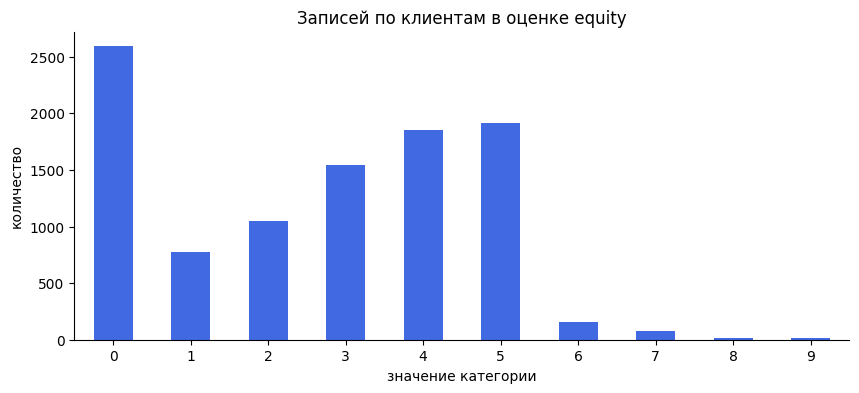

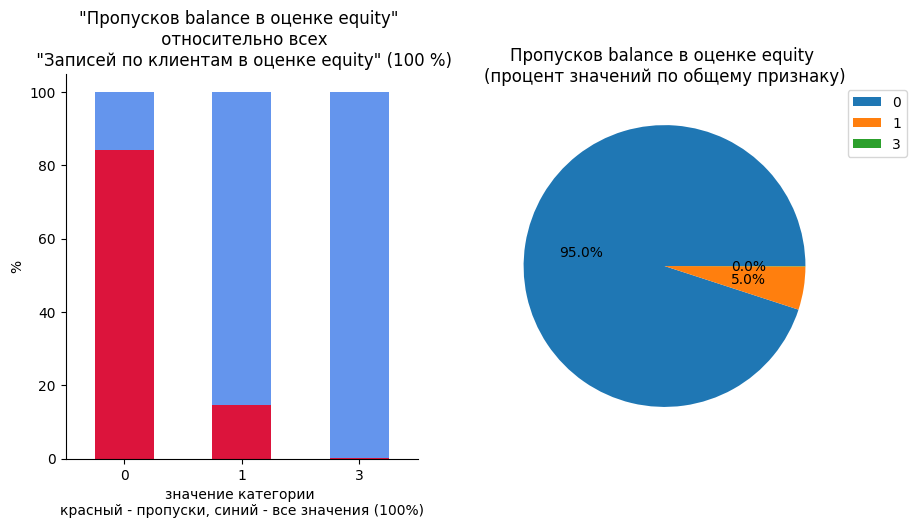

In [14]:
miss_b = raw_data.loc[raw_data['balance'].isna()]
graf_char_index(miss_b, 'equity', 'Пропусков balance в оценке equity', 
                raw_data, True, 'Записей по клиентам в оценке equity', 
                xlabel_sub_definition = 'красный - пропуски, синий - все значения (100%)')

- 95 % пропусков в balance у оценок equity равной нулю.
- В записях, где оценка собственности равна нулю обычно отсуствует значение balance - пропуск.

Посмотрим данные по products.

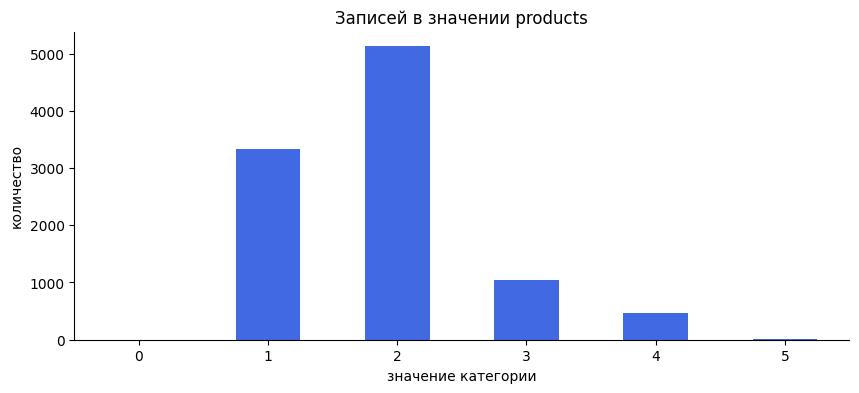

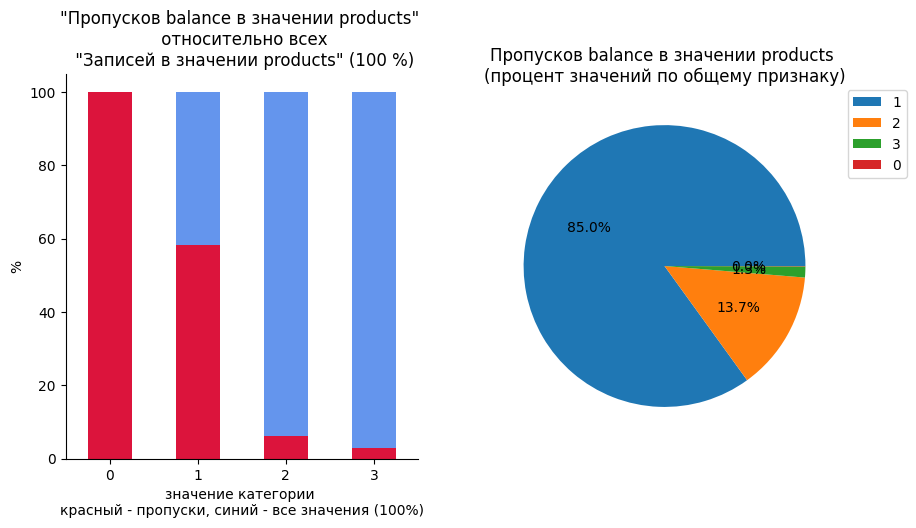

In [15]:
graf_char_index(miss_b, 'products', 'Пропусков balance в значении products', 
                raw_data, True, 'Записей в значении products',
                xlabel_sub_definition = 'красный - пропуски, синий - все значения (100%)')

- Пропуск с количеством products равным нулю - единственная запись.
- 85 % пропсков относиться к количеству продуктов равным одному. Среди всех записей с этой оценкой это - 58.4 %

Посмотрим характеристики данных в срезе с пропусками в balance по городам и количество пропусков относительно всех записей в каждом городе.

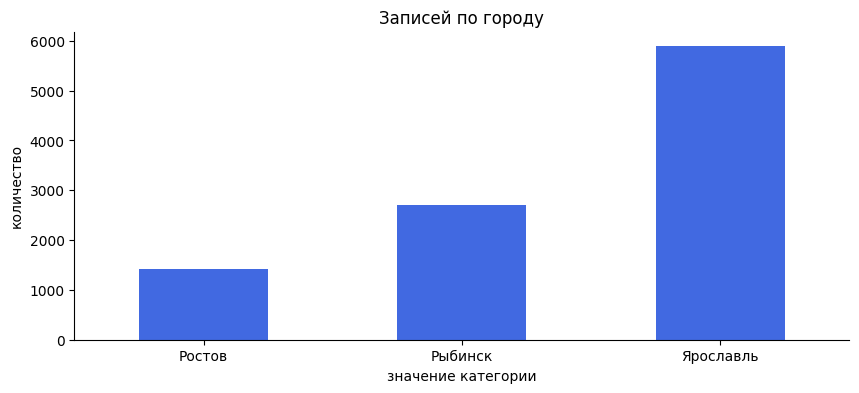

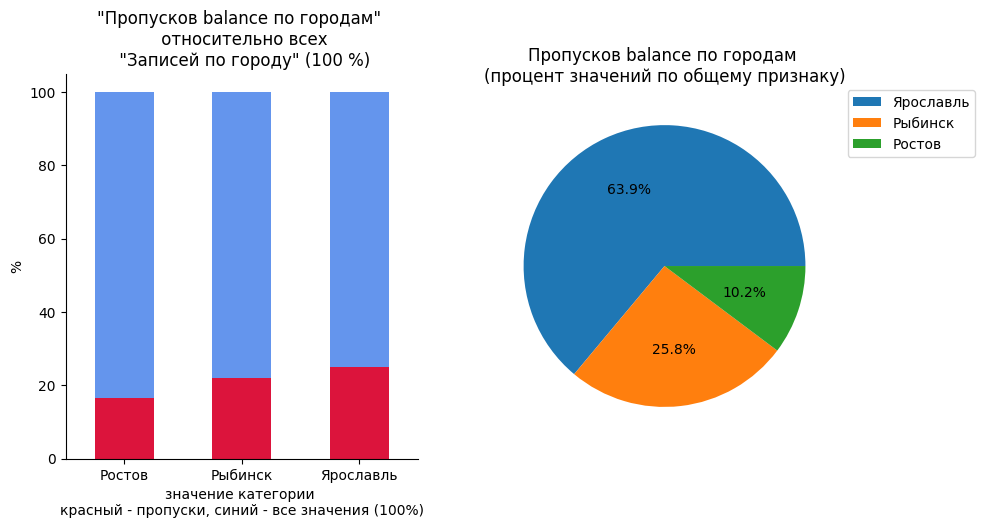

In [16]:
graf_char_index(miss_b, 'city', 'Пропусков balance по городам', 
                raw_data, True, 'Записей по городу', 
               xlabel_sub_definition = 'красный - пропуски, синий - все значения (100%)')

- Во всех городах процент пропусков относительно записей по этим городам от 18 % до 25 %.

Посмотрим остальные характеристики в срезе: пол, наличие кредитной карты, активность, признак оттока, рейтинг, возраст, оценный доход. И посмотрим их отношение ко всему датафрейму.

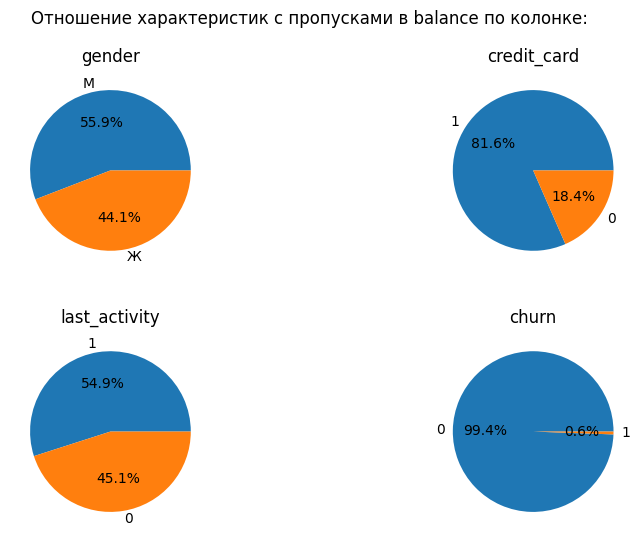

In [17]:
fig, ax = plt.subplots(2,2, figsize = (10,6))
plt.suptitle('Отношение характеристик с пропусками в balance по колонке:')
for i, column in enumerate(['gender', 'credit_card', 'last_activity', 'churn']):
    bins = "{0:b}".format(i) # plot matrix - 2x2 only
    if len(bins) == 1:
        bins = '0' + bins
    first = int(bins[0])
    second = int(bins[1])
    (miss_b[column].value_counts()/miss_b.shape[0]*100).plot(kind = 'pie', ax = ax[first, second], autopct='%1.1f%%',
                                                         title = f'{column}',
                                                         ylabel = '')
    plt.subplots_adjust(hspace=0.3)
plt.show()

- Мужчин с пропусками немного больше, чем женщин с пропусками.
- Чуть больше половины клиентов с пропусками в balance - являются активными.
- Это не отточные клиенты.
- 81.6 % клиентов  пропусками имеют кредитную карту.

Посмотрим как количество записей характеристик в срезе относиться ко всем записям по характеристике.

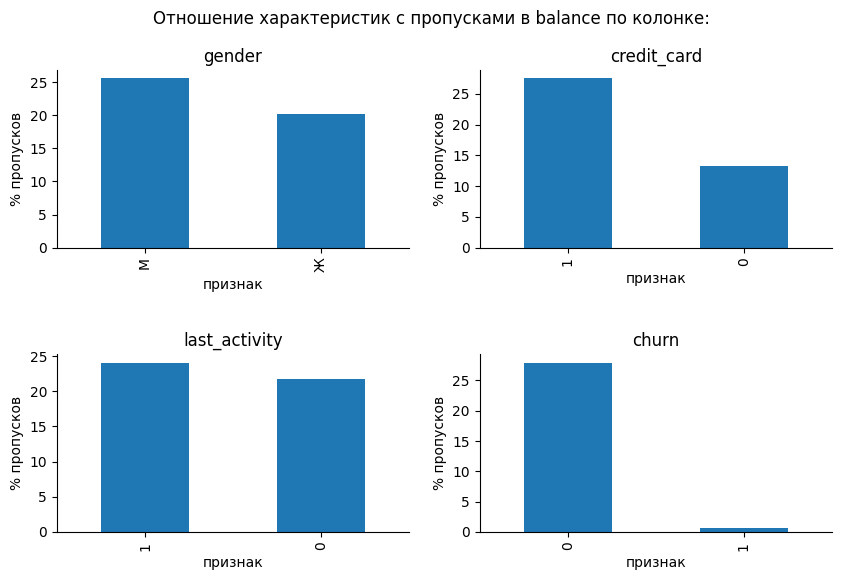

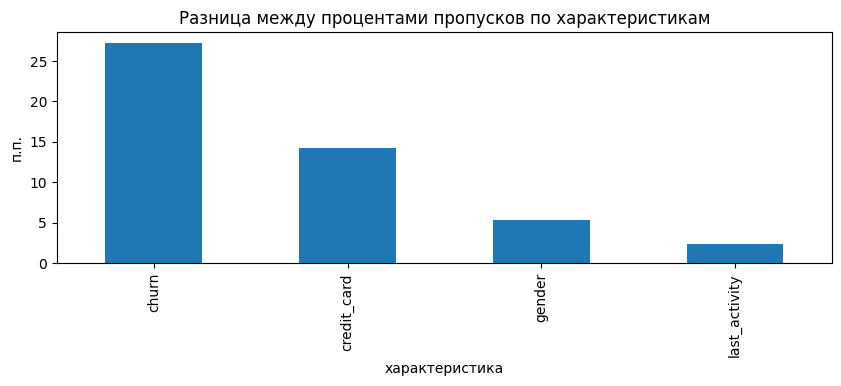

In [18]:
pct_diff = {}
fig, ax = plt.subplots(2,2, figsize = (10,6))
plt.suptitle('Отношение характеристик с пропусками в balance по колонке:')
for i, column in enumerate(['gender', 'credit_card', 'last_activity', 'churn']):
    bins = "{0:b}".format(i) 
    if len(bins) == 1:
        bins = '0' + bins
    first = int(bins[0])
    second = int(bins[1])
    x = (miss_b[column].value_counts()/raw_data[column].value_counts()*100)
    pct_diff[column] = abs(x.diff()).dropna().values[0]
    x.plot(kind = 'bar', ax = ax[first, second],
           title = f'{column}', xlabel = 'признак', ylabel = '% пропусков')
    plt.subplots_adjust(hspace=0.6)
sns.despine()
pd.DataFrame.from_dict(pct_diff, orient='index').sort_values(by = 0, ascending = False).plot(kind = 'bar', legend = False,
                                                                                             figsize = (10,3),
                                                                                             title = 'Разница между процентами пропусков по характеристикам',
                                                                                             ylabel = 'п.п.', xlabel = 'характеристика')
plt.show()

- В большей степени пропуски присуствуют если отсуствует признак оттока.
- Наличие пропусков в данных не зависит от активности клиента, пола клиента, наличия кредитной карты.

Исследуем пропуски по характеристикам: age, EST_SALARY, score.

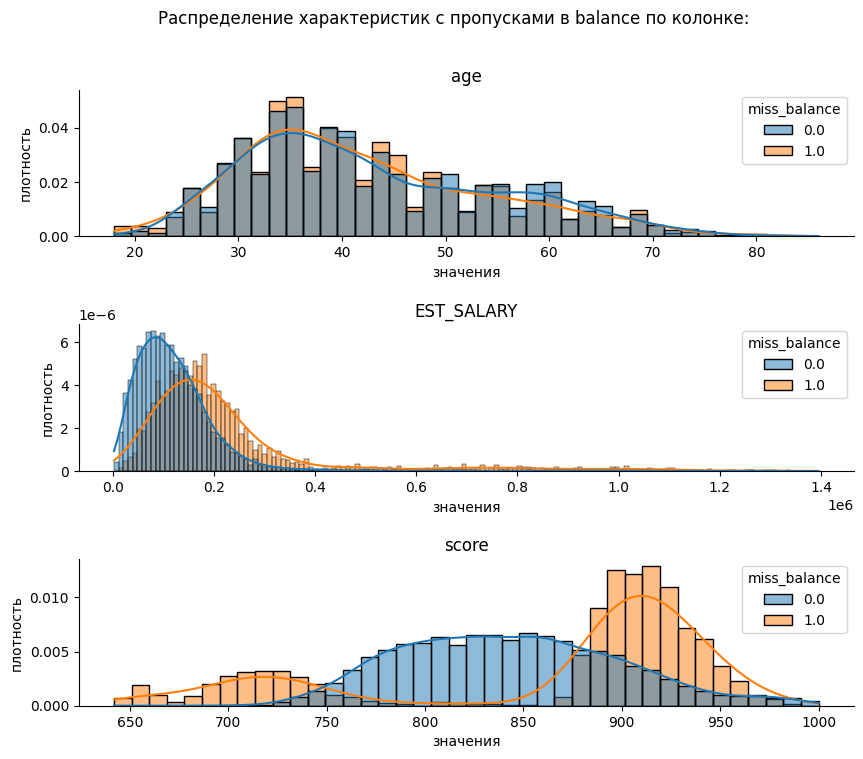

In [19]:
fig, ax = plt.subplots(3,1, figsize = (10,8))
plt.suptitle('Распределение характеристик с пропусками в balance по колонке:')
for i, column in enumerate(['age', 'EST_SALARY', 'score']):
    sns.histplot(data = raw_data, x = column, hue = 'miss_balance', 
                 stat="density", common_norm=False, ax = ax[i], kde = True)
    ax[i].set_title(column)
    ax[i].set_xlabel('значения')
    ax[i].set_ylabel('плотность')
    plt.subplots_adjust(hspace=0.6)
sns.despine()

In [20]:
raw_data.pivot_table(index = 'miss_balance', values = ['score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'EST_SALARY', 'churn',
       'miss_balance', 'miss_age'], aggfunc =  {'score':['mean','median'],'equity': 'median', 'balance':['mean','median'], 'products':'median', 'credit_card':'median','last_activity':'median','EST_SALARY':['mean','median']})

EST_SALARY                  balance           credit_card  \
                       mean     median          mean    median      median   
miss_balance                                                                 
0.0           124501.872366  106222.20  827794.30651  524272.2  1            
1.0           226310.208654  174160.68 NaN           NaN        1            

             equity last_activity products      score         
             median        median   median       mean median  
miss_balance                                                  
0.0           4      1             2        843.73926  840.0  
1.0           0      1             1        865.35207  903.0

- Пропуски не связаны с характеристиками age, EST_SALARY, score. Все клиенты имеют разные возроста, доходы и рейтинг.

В целом пропуски в колонке balance - скорее не случайны и тестно связаны с оценкой количества собственности равной нулю (MNAR). Потери данных значительны замена значений на медианны или среднее внесло бы сильное искажение. Удаление так же не возможно из-за связанных других характеристик. 
- Пропуски в balance остаются в неизменном состоянии.

Посмотрим пропуски в age. Так как их немного, то выведем все строки.

In [21]:
raw_data.pivot_table(index = 'miss_age', values = ['score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'EST_SALARY', 'churn',
       'miss_balance', 'miss_age'], aggfunc =  {'score':['mean','median'],'equity': 'median', 'balance':['mean','median'], 'products':'median', 'credit_card':'median','last_activity':'median','EST_SALARY':['mean','median']})

EST_SALARY                   balance             credit_card  \
                   mean      median          mean      median      median   
miss_age                                                                    
0.0       147786.809731  119626.795  8.272456e+05  524295.330  1            
1.0       178585.199231  142598.860  1.250034e+06  417361.115  1            

         equity last_activity products       score         
         median        median   median        mean median  
miss_age                                                   
0.0       3      1             2        848.682575  853.0  
1.0       0      1             1        855.153846  888.5

In [22]:
miss_a = raw_data.loc[raw_data['age'].isna()]
miss_a.sort_values(by = 'USERID')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,miss_balance,miss_age
8785,127440,663.0,Ярославль,М,NaN,0,NaN,1,1,1,117197.56,0,1.0,1.0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1,0.0,1.0
9819,140934,832.0,Рыбинск,Ж,NaN,3,385763.16,2,0,1,59651.35,0,0.0,1.0
9457,141945,929.0,Ярославль,М,NaN,0,NaN,1,1,0,381868.89,0,1.0,1.0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0,1.0,1.0
9667,163657,849.0,Ярославль,М,NaN,4,1254013.85,2,1,1,119106.67,0,0.0,1.0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0,0.0,1.0
9632,185829,927.0,Ярославль,М,NaN,0,NaN,1,1,0,231254.86,0,1.0,1.0
9380,187459,894.0,Рыбинск,М,NaN,0,NaN,1,1,0,178012.28,0,1.0,1.0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0,1.0,1.0


В целом наблюдений с пропусками в age мало и они слабо коррелируют с остальными данными. Эти пропуски выглядят, как возникшие абсолютно случайно. Так как их в целом 0.26 %, то можно их как удалить, так и заполнить (медианным значением) - влияние будет минимальное.
- Пропуски в age заполним медианной.

**Дубликаты**

Посмотрим количество дубликатов и как они дублируются.

In [23]:
print('Количество полных дубликатов строк:', raw_data.duplicated().sum(),
     "\nДубликатов по USERID:\n", (raw_data.loc[raw_data.duplicated(subset='USERID', keep = False)]
                               .groupby('USERID')['score'].count().value_counts()))

Количество полных дубликатов строк: 0 
Дубликатов по USERID:
 2    73
Name: score, dtype: int64


Каждая из 73 строк имеет 1 дубликат по USERID. Исследуем дубликаты по USERID и остальным характеристикам.

In [24]:
 raw_data[raw_data.duplicated(subset = ['USERID', 'EST_SALARY'], keep = False)]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,miss_balance,miss_age
4343,141945,929.0,Рыбинск,М,33.0,0,NaN,1,1,0,381868.89,0,1.0,0.0
9457,141945,929.0,Ярославль,М,NaN,0,NaN,1,1,0,381868.89,0,1.0,1.0


In [25]:
 raw_data[raw_data.duplicated(subset = ['USERID', 'age'], keep = False)].sort_values(by = "USERID")

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,miss_balance,miss_age
5252,148826,895.0,Ярославль,М,32.0,5,1470273.14,2,0,0,118058.52,1,0.0,0.0
8364,148826,909.0,Рыбинск,Ж,32.0,0,NaN,3,1,0,28843.54,0,1.0,0.0
3274,155765,863.0,Ярославль,М,30.0,5,1036114.50,5,1,1,150744.50,1,0.0,0.0
5197,155765,923.0,Рыбинск,М,30.0,0,NaN,1,1,1,120296.60,0,1.0,0.0
3564,163207,853.0,Рыбинск,М,42.0,4,543839.62,1,1,1,105281.97,1,0.0,0.0
6786,163207,838.0,Ярославль,Ж,42.0,4,652776.60,2,1,1,97545.36,0,0.0,0.0
1359,211130,833.0,Ярославль,М,55.0,3,1231184.90,4,0,1,187758.38,1,0.0,0.0
3817,211130,918.0,Рыбинск,Ж,55.0,0,NaN,2,1,1,244202.04,0,1.0,0.0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1,0.0,0.0
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0,0.0,0.0


In [26]:
 raw_data[raw_data.duplicated(subset = ['USERID', 'score'], keep = False)].sort_values(by = "USERID")

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,miss_balance,miss_age
4343,141945,929.0,Рыбинск,М,33.0,0,NaN,1,1,0,381868.89,0,1.0,0.0
9457,141945,929.0,Ярославль,М,NaN,0,NaN,1,1,0,381868.89,0,1.0,1.0
9322,221809,917.0,Рыбинск,М,45.0,0,NaN,1,1,1,199728.29,0,1.0,0.0
9634,221809,917.0,Ярославль,М,NaN,0,NaN,1,1,1,192644.15,0,1.0,1.0
6446,222480,776.0,Ярославль,Ж,38.0,5,823145.83,2,1,1,55777.44,0,0.0,0.0
9104,222480,776.0,Рыбинск,Ж,NaN,5,796735.09,1,1,1,55073.63,0,0.0,1.0


In [27]:
 raw_data[raw_data.duplicated(subset = ['USERID', 'city'], keep = False)]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,miss_balance,miss_age


Каждая из 73 строк имеет 1 дубликат по USERID. Так как извесно, что при расторжении или прекращении отношений с банком userid ушедшего может присвоиться другому клиенту, то на основе имеющихся данных невозможно однозначно идентифицировать клиента. То есть вполне может быть, что под одним id находятся разные клиенты со схожими характеристиками. К тому же у всех них разные города. Клиент мог переехать, но неизвесно какая запись является актуальной - временные метки получения данных отсуствуют. На вид - пробелмы с базой данных приимущественно в Рыбинске и Ярославле. Так как для построения портрета клиента и выделения сегментов необходимы паттерны (чем является каждая строка датафрейма), то дубликаты оставляем. Дубликатов строк - 0.73 %.
- Неявные дубликаты остаются ввиду невозможности утверждать, что за ними находится одна и та же персона.

**Итого.** 

В целом данные соответсвуют заявленным. Пропуски в balance оставим как есть. 
Проведём предобработку по пунктам:
 - Исправим значения в записи 8957 в колонках: products заменим на 1, balance заменим на 0.
 - Пропуски в age заменим медианным значением.
 - Колонки приведём к нижнему регистру.
 - Добавим колонки с кодированием категориальных данных для колонок: gender, и значений city.

<a id="preprocessing"></a>
### [Предобработка](#description)

Приведём колонки с целыми значениями к целочисленному типу меньшей размерности (к int8).

In [28]:
for column in ['equity', 'products', 'credit_card', 'last_activity', 'churn', 'miss_balance', 'miss_age']:  
    raw_data[column] = raw_data[column].astype('int8') 
data = raw_data.copy(deep = True)
data = data.drop(columns = ['miss_age'])

Приведём названия колонок к нижнему регистру.

In [29]:
data.columns = [x.lower() for x in data.columns]
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn',
       'miss_balance'],
      dtype='object')

Закодируем категориальные значения столбца gender и city - запишем их в отдельные столбцы.

In [30]:
data = data.join(pd.get_dummies(data['city'], dtype='int8'))
data = data.join(pd.get_dummies(data['gender'], dtype='int8'))

Заполним пропуски в age медианной.

In [31]:
display(about_data(data, ['age']))
print(f"Mean: before - {raw_data['age'].mean()}, after - {data['age'].mean()}")

➡️ Entered data type: DataFrame


,total_nan,%_nan,duplicated,nunique,non_null,type
age,26,0.26,9906,68,9974,float64


Mean: before - 42.73440946460798, after - 42.73440946460798


Исправим значение в записи 8957, на один продукт, balance на 0.

In [32]:
data.loc[8957, 'products'] = 1
data.loc[8957, 'balance'] = 0

<a id="final_overview"></a>
### [Итоговый обзор](#description)

В этом разделе подводится итог по выявленным проблемам и их решения. Так же приводятся изменения после предидущих пунктов.

In [33]:
display(about_data(data),data.head())

➡️ Entered data type: DataFrame


,total_nan,%_nan,duplicated,nunique,non_null,type
userid,0.0,0.00,73.0,9927.0,10000.0,int64
Ярославль,0.0,0.00,9998.0,2.0,10000.0,int8
Рыбинск,0.0,0.00,9998.0,2.0,10000.0,int8
Ростов,0.0,0.00,9998.0,2.0,10000.0,int8
miss_balance,0.0,0.00,9998.0,2.0,10000.0,int8
churn,0.0,0.00,9998.0,2.0,10000.0,int8
est_salary,0.0,0.00,4.0,9996.0,10000.0,float64
last_activity,0.0,0.00,9998.0,2.0,10000.0,int8
credit_card,0.0,0.00,9998.0,2.0,10000.0,int8
products,0.0,0.00,9995.0,5.0,10000.0,int8


,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,miss_balance,Ростов,Рыбинск,Ярославль,Ж,М
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,0,1,0,1


Колонка age не содержит пропусков: 
- 46 пропусков в age заполнены медианной по age.
- Пропуски в колонке balance в количестве 2295 остались, так как ни заполнить ни удалить их невозможно. Пропуски имеют сильную связь со значением в equity равным "нулю". Так же есть связь с значением количества продуктов равным "одному".
- Датафрейм содержит 5 колонок с признаками города (Ростов, Рыбинск, Ярославль) и пола (Ж и М).
- Названия всех колонок в нижнем регистре.
- Дубликаты строк по userid остались ввиду невозможности однозначной идентификации клиента.
___

<a id="research"></a>
## [Исследование](#description)

<a id="churn"></a>
### [Общий отток](#description)

Расчёт среднего оттока (%) по банку. В начале посмотрим, какой процент отточных клиентов в целом по банку.

In [34]:
churn_line = (data.churn.sum()/data.shape[0])*100 #значение оттока среднего по банку

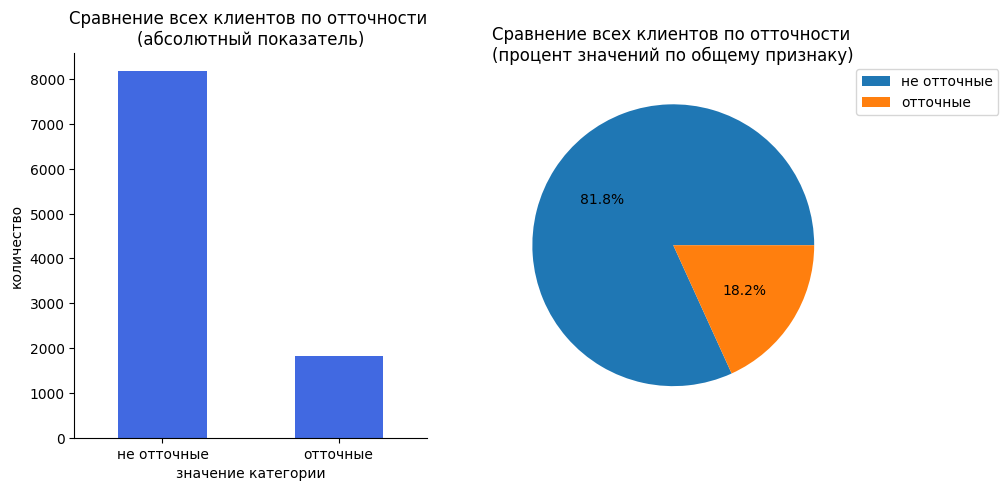

77.75 %


In [35]:
graf_char_index(data, 'churn', 'Сравнение всех клиентов по отточности', 
                custom_labels = ['не отточные', 'отточные'])
no_churn = (data.shape[0] - data.churn.sum())
churn = data.churn.sum()
print(round((abs(churn - no_churn)/no_churn)*100,2), "%")

- Клиентов с признаком оттока - 18.2 % по банку. При этом отточных меньше относительно неотточных на 77.75 %.

<a id="general_view"></a>
### [Обобщённый портерт](#description)

В этом разделе рассматриваются все характеристики в обобщённом виде в разрезе отточных клиентов и не отточных. 
На основе этих данных составляется словесное описание типичного отточного и не отточного клиента.

In [36]:
portrait(data)

churn,sing,parameter,no_churn,yes_churn
0,age,mean,43.020846,41.450247
14,age,mean_diff_pct,3.789118,-3.650785
1,age,median,40.0,39.0
15,age,median_diff_pct,2.564103,-2.5
2,balance,mean,733982.585648,1133366.062782
16,balance,mean_diff_pct,-35.238701,54.413209
3,balance,median,475382.445,781540.965
17,balance,median_diff_pct,-39.173701,64.402572
13,city,,Ярославль,Ярославль
11,credit_card,,1.0,1.0


**Обобщённый портрет не отточного клиента:** <br>
        
Это обычно пассивный клиент женского пола около 40 лет, пользующися 2 продуктами банка, имеющий кредитную карту. Обычно с уровнем дохода в среднем 118257, оценкой ликвидности собственности 3, кредитным рейтингом около 848, и средним балансом на счёте 475382 (то есть примерно 4 средних дохода).

**Обобщённый портрет отточного клиента:** <br>
Это обычно активный клиент мужского пола около 40 лет, пользующися 2 продуктами банка, имеющий кредитную карту. Обычно с уровнем дохода в среднем 125390, оценкой ликвидности собственности 4, кредитным рейтингом около 866, и средним балансом на счёте 782410 (то есть примерно 6 средних доходов).

Оба клиента обычно из Ярославля, но записей в целом из этого города больше всего.
У отточных доход немного выше.

<a id="find_features"></a>
### [Исследование характеристик](#description)

<a id="find_score"></a>
#### [Рейтинг](#description)
Колонка Score.

Построим общую гистограмму и в разрезе признака оттока. После этого сравним количество по отточности по этой колонке.

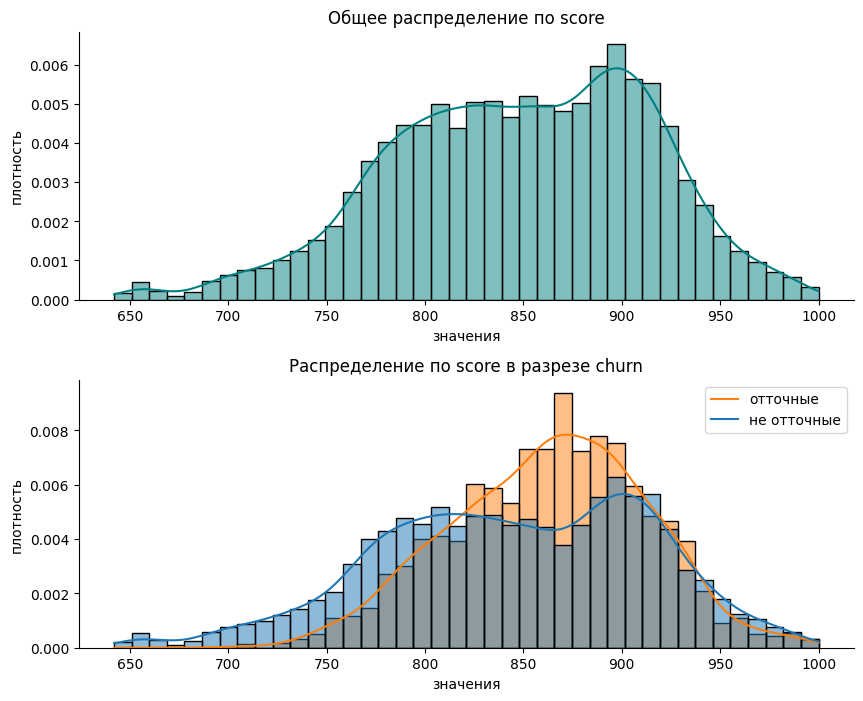

In [37]:
sns_hipt_norm(data,'score', 'churn', ['отточные','не отточные'])

Наибольший отток в диапазоне 825 - 925.

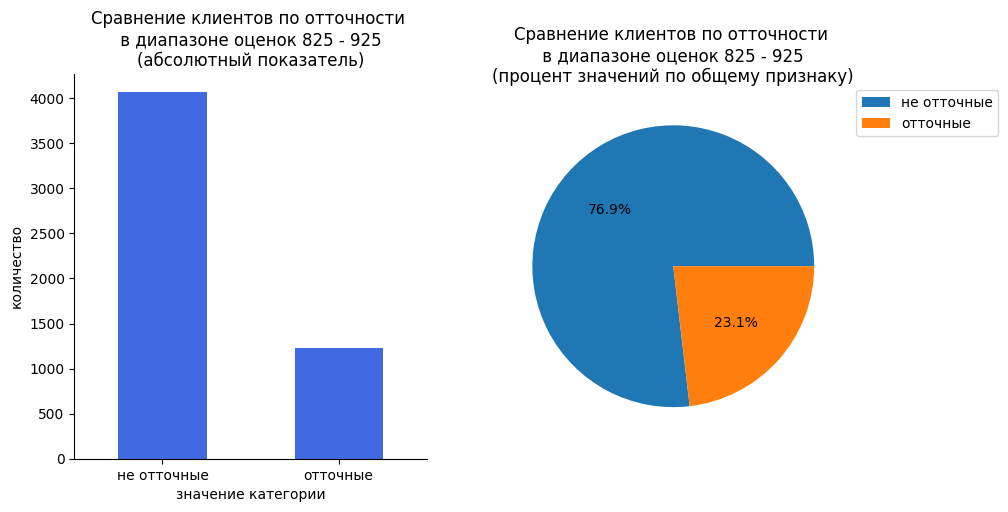

In [38]:
graf_char_index(data.loc[data['score'].between(825,925)], 'churn', 
                'Сравнение клиентов по отточности \n в диапазоне оценок 825 - 925', 
                custom_labels = ['не отточные', 'отточные'])

- Отток клиентов в диапазоне рейтинга 825 - 925 составляет 23.1 %. 

<a id="find_age"></a>
#### [Возраст](#description)

Колонка Age.

Построим общую гистограмму и в разрезе признака оттока. После этого сравним количество по отточности по этой колонке.

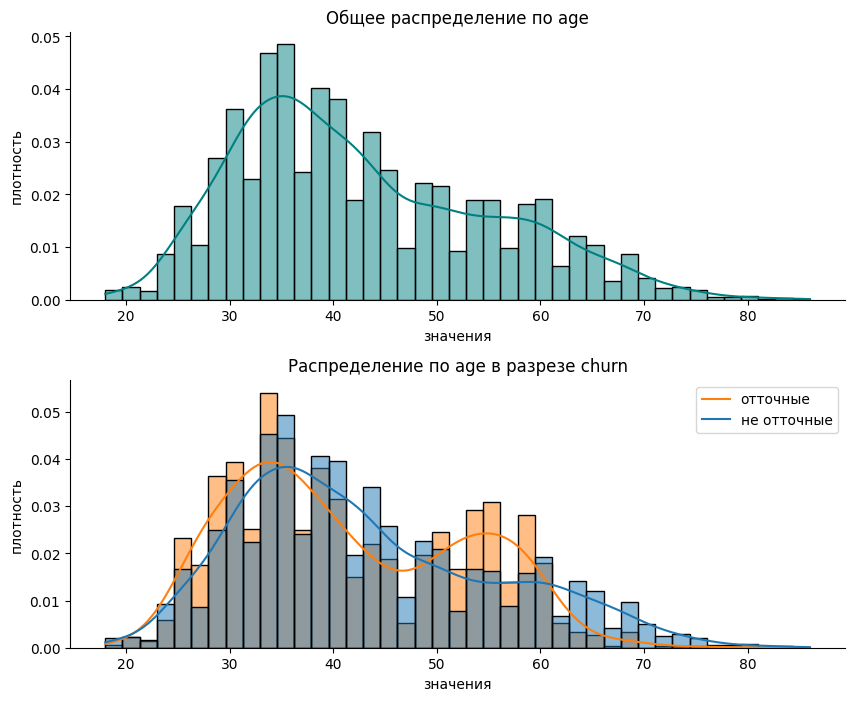

In [39]:
sns_hipt_norm(data,'age', 'churn', ['отточные','не отточные'])

Наибольший отток в диапазонах от 25 до 35 и от 50 до 60.

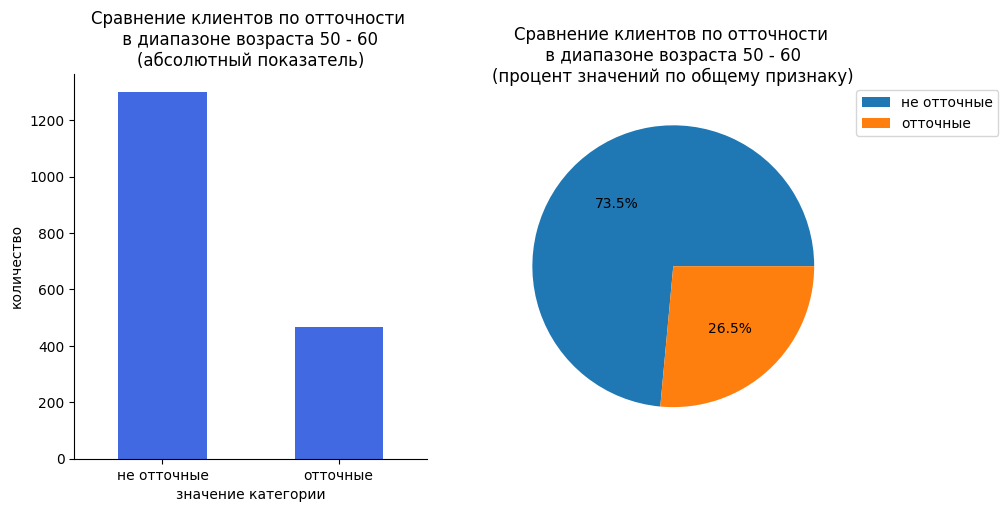

In [40]:
graf_char_index(data.loc[(data['age'].between(50,60))], 'churn', 
                'Сравнение клиентов по отточности \n в диапазоне возраста 50 - 60', 
                custom_labels = ['не отточные', 'отточные'])

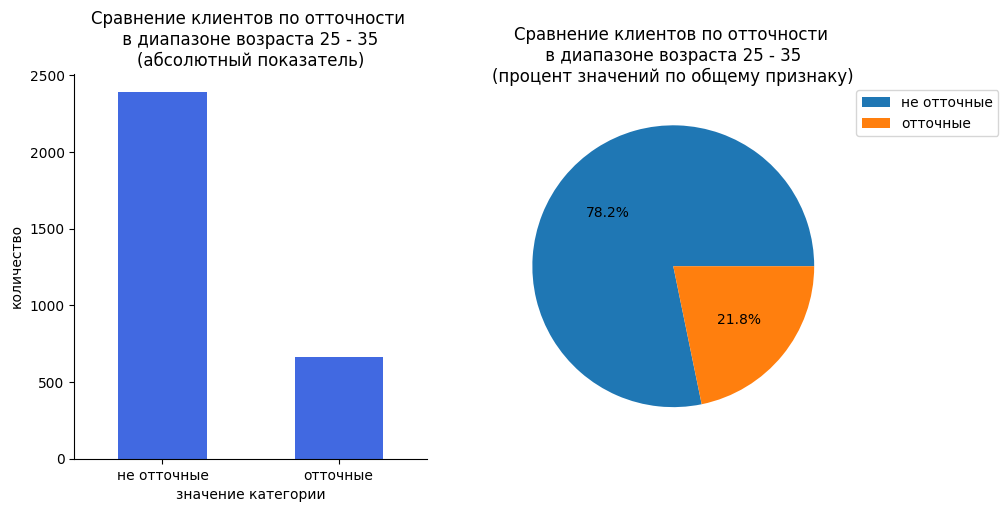

In [41]:
graf_char_index(data.loc[(data['age'].between(25,35))], 'churn', 
                'Сравнение клиентов по отточности \n в диапазоне возраста 25 - 35', 
                custom_labels = ['не отточные', 'отточные'])

In [42]:
data.loc[data['age'].between(50,60),'sin_age'] = 1 #Отметка
data.loc[data['age'].between(25,35),'sin_age'] = 1 #Отметка
data['sin_age'] = data['sin_age'].fillna(0)

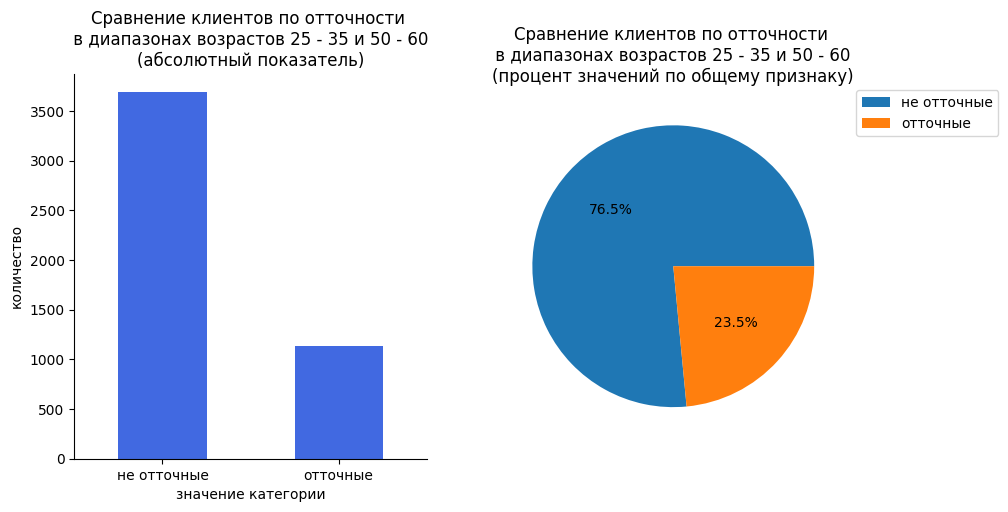

In [43]:
graf_char_index(data.loc[data['sin_age'] == 1], 'churn',
                'Сравнение клиентов по отточности \n в диапазонах возрастов 25 - 35 и 50 - 60', custom_labels = ['не отточные', 'отточные'])

- В диапазоне 25 - 35 лет отток составляет 21.8 %.
- В диапазоне 50 - 60 лет отток 26.5 %.
- Объеденённая группа 25 - 35 лет и 50 - 60 лет - отток 23.5 %.

<a id="find_balance"></a>
#### [Баланс на счёте](#description)

Колонка Balance.

Построим общую гистограмму и в разрезе признака оттока. После этого сравним количество по отточности по этой колонке.\
Возмём масштаб до 4 млн. так как значений свыше - мало.

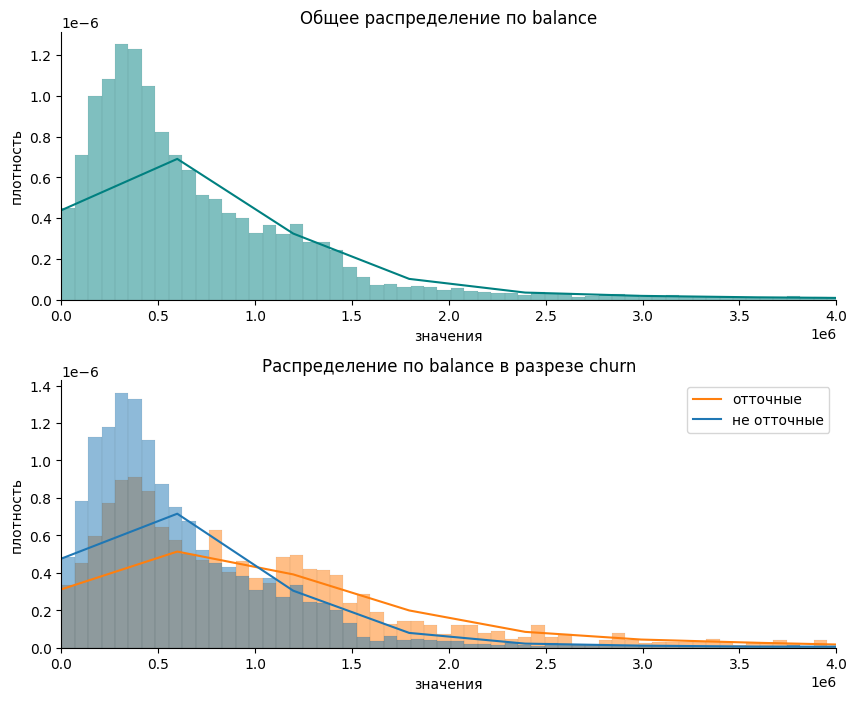

In [44]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
sns.histplot(data = data, x = 'balance', stat="density", 
                 common_norm = False, kde=True, ax = ax[0], color = '#008080')
plt.subplots_adjust(hspace=0.3)
sns.histplot(data = data, x = 'balance', hue = 'churn', stat="density",  
                 ax = ax[1], common_norm = False, kde=True)
ax[0].set_xlim(0,4000000)
ax[1].set_xlim(0,4000000)
ax[0].set_ylabel('плотность')
ax[1].set_ylabel('плотность')
ax[0].set_xlabel ('значения')
ax[1].set_xlabel ('значения')
ax[0].set_title(f'Общее распределение по balance')
ax[1].set_title(f'Распределение по balance в разрезе churn')
ax[1].legend(['отточные','не отточные'])
sns.despine()
plt.show()

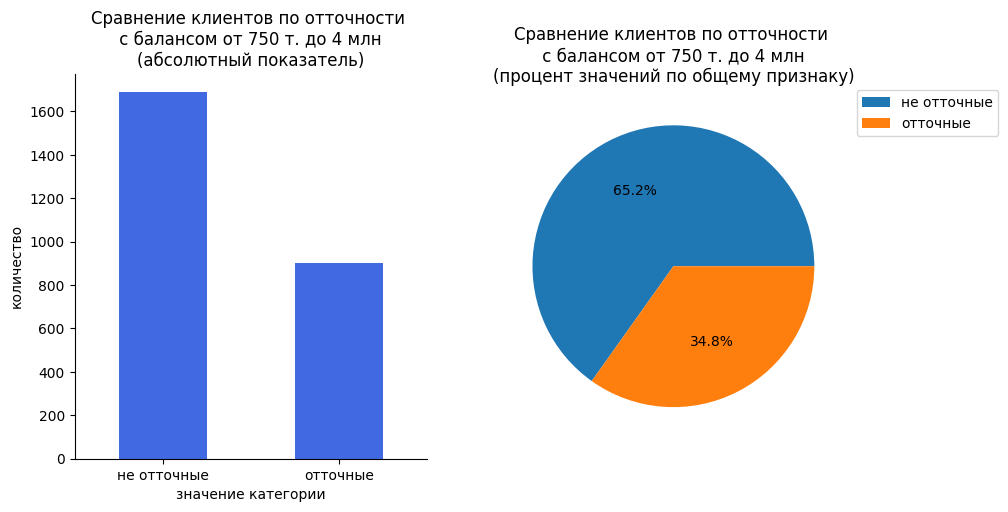

In [45]:
graf_char_index(data.loc[(data['balance'].between(750000,4000000))], 'churn', 
                'Сравнение клиентов по отточности \n с балансом от 750 т. до 4 млн', 
                custom_labels = ['не отточные', 'отточные'])

- Отток клиентов с балансом от 750 тысяч до 4 млн. составляет 34.8 %.

<a id="find_est_salary"></a>
#### [Оценочный доход](#description)

Колонка est_salary.

Построим общую гистограмму и в разрезе признака оттока. После этого сравним количество по отточности по этой колонке.\
Возмём масштаб до 500 т. так как значений свыше - мало.

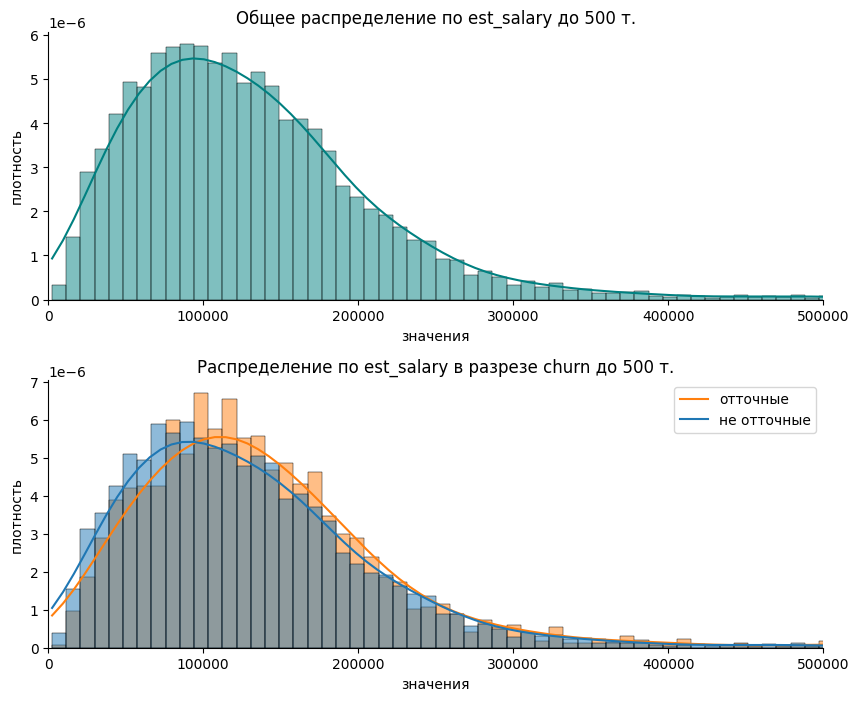

In [46]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
sns.histplot(data = data, x = 'est_salary', stat="density", 
                 common_norm = False, kde=True, ax = ax[0], color = '#008080')
plt.subplots_adjust(hspace=0.3)
sns.histplot(data = data, x = 'est_salary', hue = 'churn', stat="density",  
                 ax = ax[1], common_norm = False, kde=True)
ax[0].set_xlim(0,500000)
ax[1].set_xlim(0,500000)
ax[0].set_ylabel('плотность')
ax[1].set_ylabel('плотность')
ax[0].set_xlabel ('значения')
ax[1].set_xlabel ('значения')
ax[0].set_title('Общее распределение по est_salary до 500 т.')
ax[1].set_title('Распределение по est_salary в разрезе churn до 500 т.')
ax[1].legend(['отточные','не отточные'])
sns.despine()
plt.show()

Наибольший отток в диапазоне от 100 до 220 т.

In [47]:
data.loc[data['est_salary'].between(100000,220000),'sin_est_salary'] = 1
data['sin_est_salary'] = data['sin_est_salary'].fillna(0)

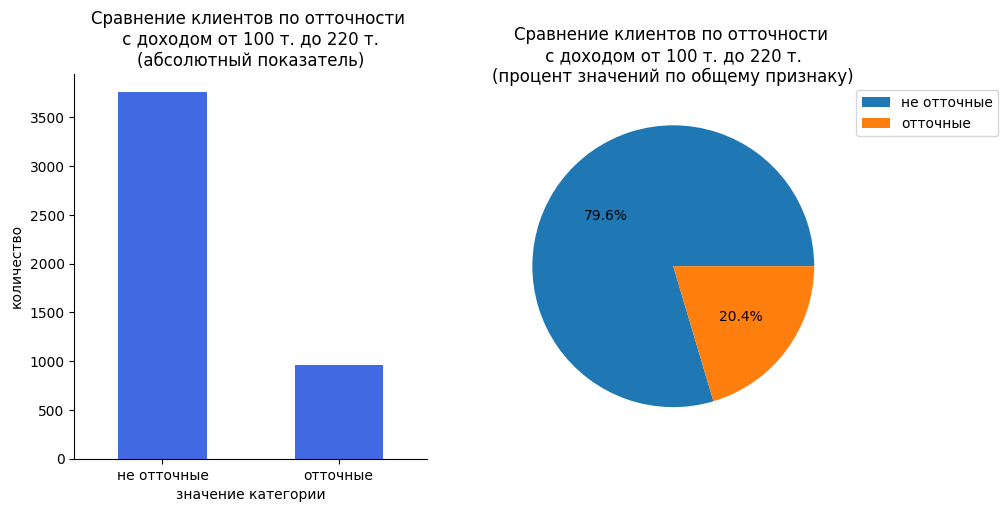

In [48]:
graf_char_index(data.loc[data['est_salary'].between(100000,220000)], 'churn', 
                'Сравнение клиентов по отточности \n с доходом от 100 т. до 220 т.', 
                custom_labels = ['не отточные', 'отточные'])

- Отточных клиентов больше с доходом от 100 т. до 220 т. - 20.4 %.

<a id="find_city"></a>
#### [Город](#description)

Колонка City.

Построим столбчатую диаграмму по количеству записей в общем в абсолютных значениях. И построим столбчатую диаграмму с относительным количеством отточных клиентов в каждой уникальной категории. Так же построим курговую диаграмму с отношениями уникальных категорий среди только отточных клиентов.

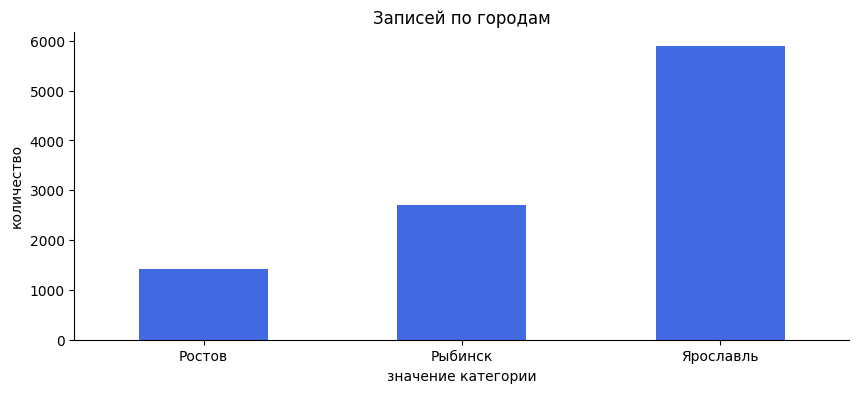

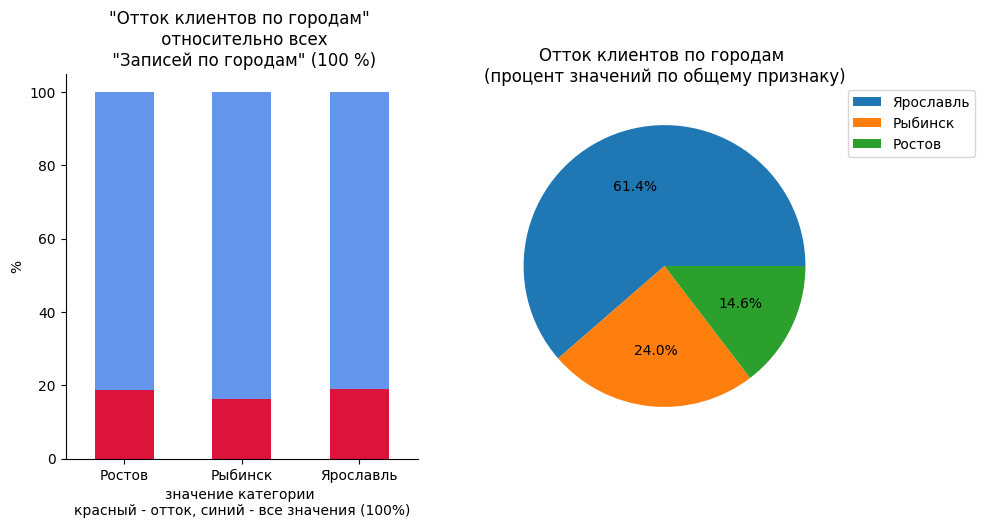

In [49]:
graf_char_index(data[data['churn'] == 1], 'city', 'Отток клиентов по городам', 
                data, True, 'Записей по городам', 
                xlabel_sub_definition = 'красный - отток, синий - все значения (100%)')

- В Ярославле больше всего отточных клиентов - 61.4 %, по отношению к отточным клиентам в других городах. На втором месте Рыбинск. На третьем ростов.
- Общий отток по городу относительно всех клиентов этого отделения в городе в Ярославле схожий с Ростовом - 18%.

<a id="find_gender"></a>
#### [Пол клиента](#description)
Колонка Gender.

Построим столбчатую диаграмму по количеству записей в общем в абсолютных значениях. И построим столбчатую диаграмму с относительным количеством отточных клиентов в каждой уникальной категории. Так же построим курговую диаграмму с отношениями уникальных категорий среди только отточных клиентов.

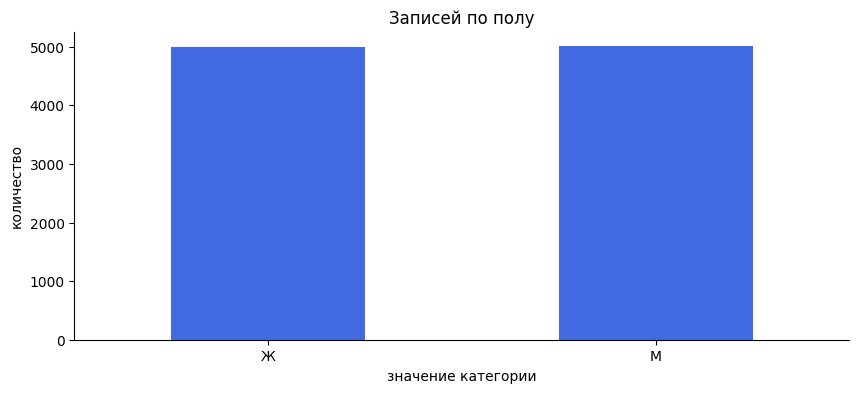

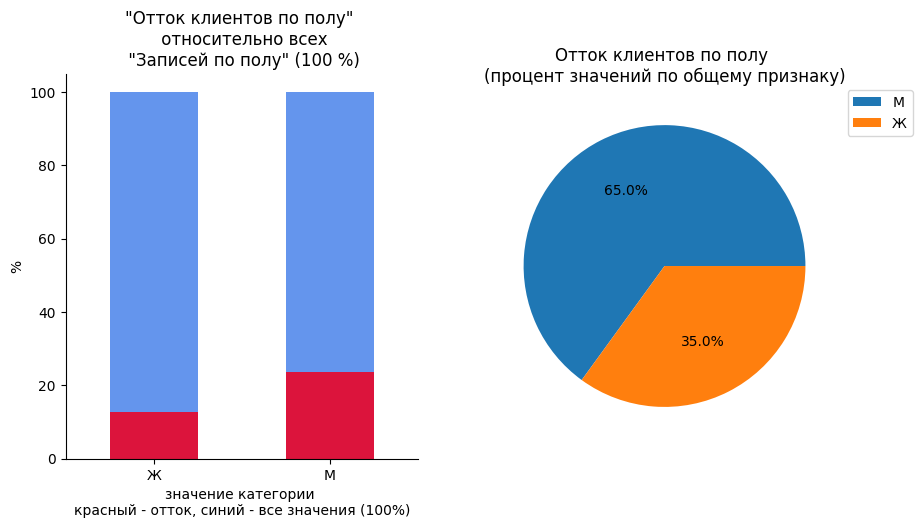

In [50]:
graf_char_index(data[data['churn'] == 1], 'gender', 'Отток клиентов по полу', 
                data, True, 'Записей по полу',
                xlabel_sub_definition = 'красный - отток, синий - все значения (100%)')

Отток клиентов мужчин выше (24 %), чем женщин (13 %). Срежи отточных клиентов мужчин больше - 65 %, женщин - 35 %.
- Отто клиентов мужчин больше, чем женщин.

<a id="find_equity"></a>
#### [Ликвидность собстенности](#description)
Колонка Equity.

Построим столбчатую диаграмму по количеству записей в общем в абсолютных значениях. И построим столбчатую диаграмму с относительным количеством отточных клиентов в каждой уникальной категории. Так же построим курговую диаграмму с отношениями уникальных категорий среди только отточных клиентов.

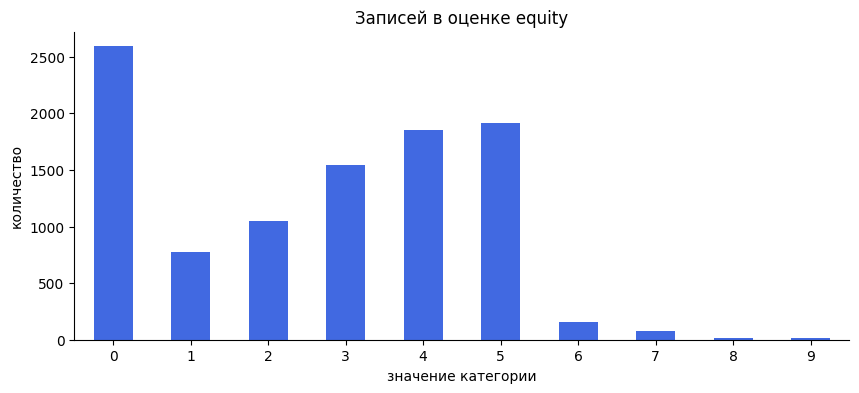

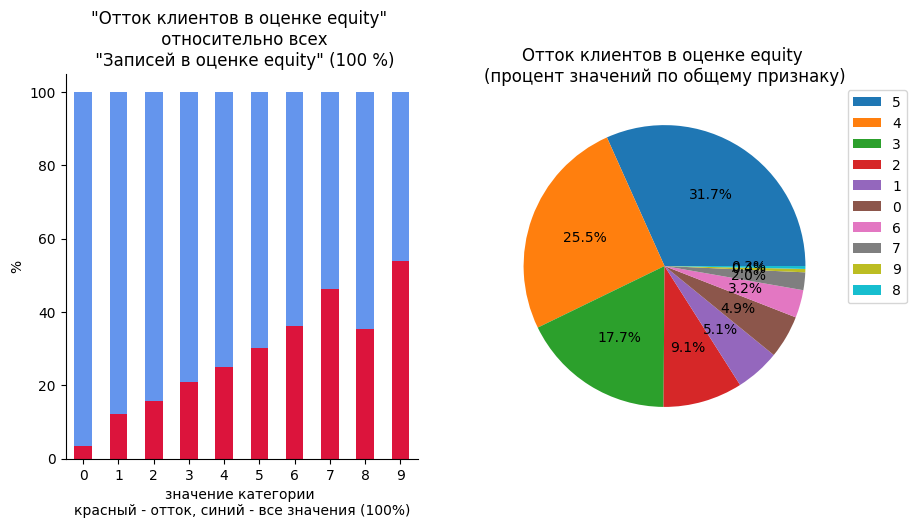

In [51]:
graf_char_index(data[data['churn'] == 1], 'equity', 'Отток клиентов в оценке equity', 
                data, True, 'Записей в оценке equity', 
                xlabel_sub_definition = 'красный - отток, синий - все значения (100%)')

- Больше всего отток среди клиентов с оценками собсвенности 9 и 7. Но их - малое колоичество.
- Количество клиентов с оценкой 5, 4 и 3 больше всего среди отточных клиентов. Уровень оттока выше, чем в среднем по банку.

<a id="find_products"></a>
#### [Количество продуктов](#description)
Колонка Products.

Построим столбчатую диаграмму по количеству записей в общем в абсолютных значениях. И построим столбчатую диаграмму с относительным количеством отточных клиентов в каждой уникальной категории. Так же построим курговую диаграмму с отношениями уникальных категорий среди только отточных клиентов.

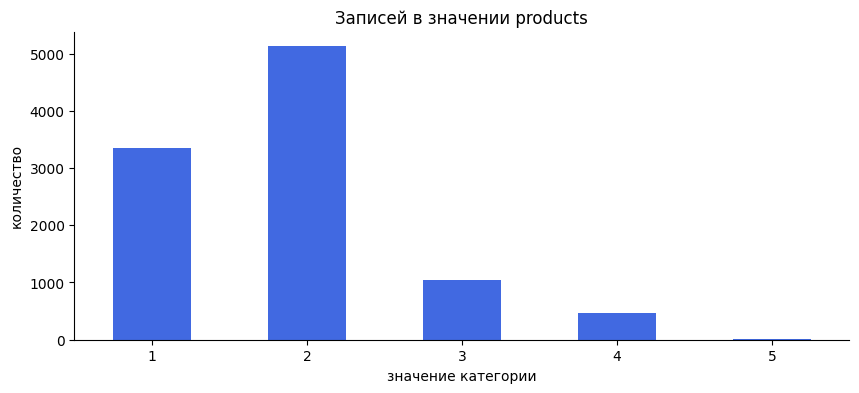

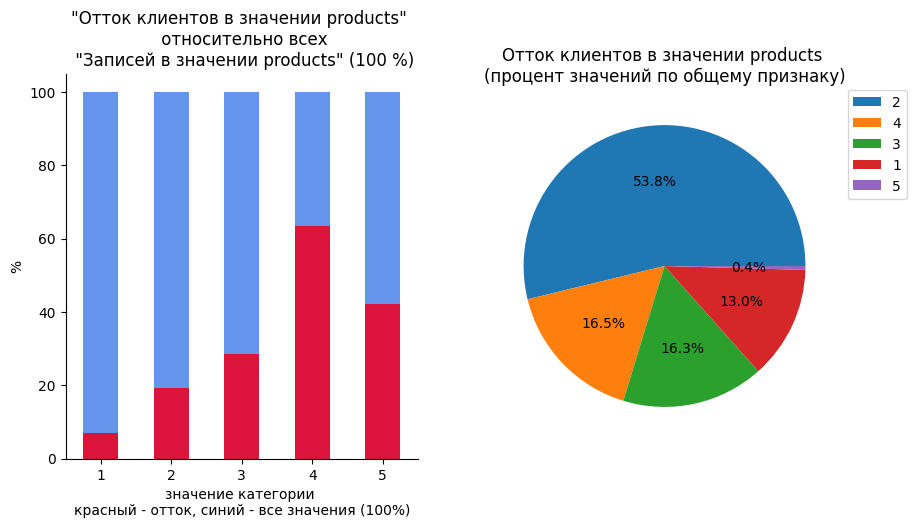

In [52]:
graf_char_index(data[data['churn'] == 1], 'products', 'Отток клиентов в значении products', 
                data, True, 'Записей в значении products', 
                xlabel_sub_definition = 'красный - отток, синий - все значения (100%)')

- Наибольший отток клиентов имеющих 4 и 5 продуктов (64 % и 44 % соотвественно). Но количество клиентов небольшое - менее 500.
- Среди отточных клиентов - больше всего с количеством продуктов 2 (53.8 %). Количество клиентов пользующихся двумя продуктами - больше остальных. Но отток среди них не большой - 20%.
- Среди отточных клиентов пользующихся тремя продуктами - 16.3 %. Отток среди клиентов с клиентов с тремя продуктами 29 %. Но клиентов в пределах 1000.

<a id="find_credit_card"></a>
#### [Наличие кредитной карты](#description)

Колонка Credit_card.

Построим столбчатую диаграмму по количеству записей в общем в абсолютных значениях. И построим столбчатую диаграмму с относительным количеством отточных клиентов в каждой уникальной категории. Так же построим курговую диаграмму с отношениями уникальных категорий среди только отточных клиентов.

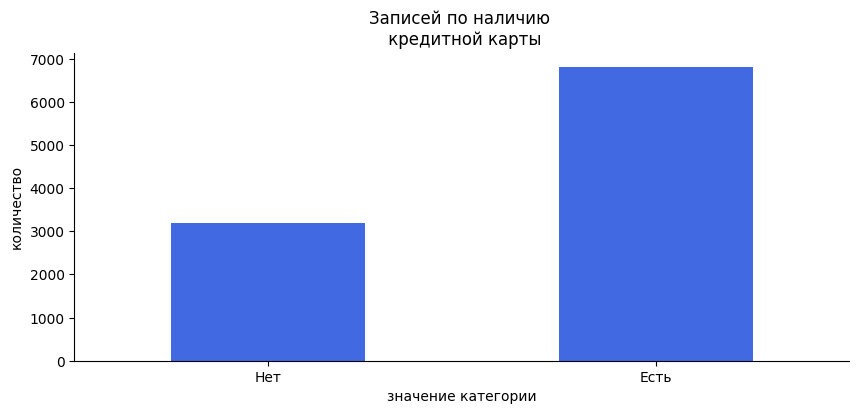

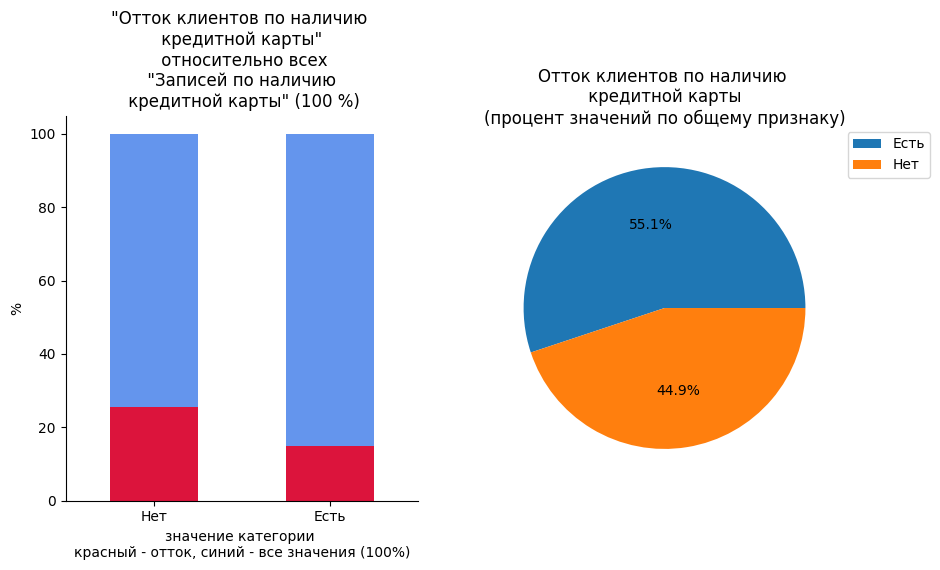

In [53]:
graf_char_index(data[data['churn'] == 1], 'credit_card', 'Отток клиентов по наличию \n кредитной карты', 
                data, True, 'Записей по наличию \n кредитной карты', 
                xlabel_sub_definition = 'красный - отток, синий - все значения (100%)',
               custom_labels100 = ['Нет', 'Есть'], main_labels = ['Нет', 'Есть'], custom_labels = ['Есть', 'Нет'])

В абсолютном количестве клиентов с кредитной картой уходит немного больше, чем у кого её нет.
- Среди всех клиентов, отток клиентов с отсутсвием кредитной карты - выше (25 %), чем у кого она есть (14 %). 
- Среди отточных клиентов количество больше у клиентов с кредитной картой - 55.1 %.

<a id="find_last_activity"></a>
#### [Активность клиента](#description)
Колонка Last_activity.

Построим столбчатую диаграмму по количеству записей в общем в абсолютных значениях. И построим столбчатую диаграмму с относительным количеством отточных клиентов в каждой уникальной категории. Так же построим курговую диаграмму с отношениями уникальных категорий среди только отточных клиентов.

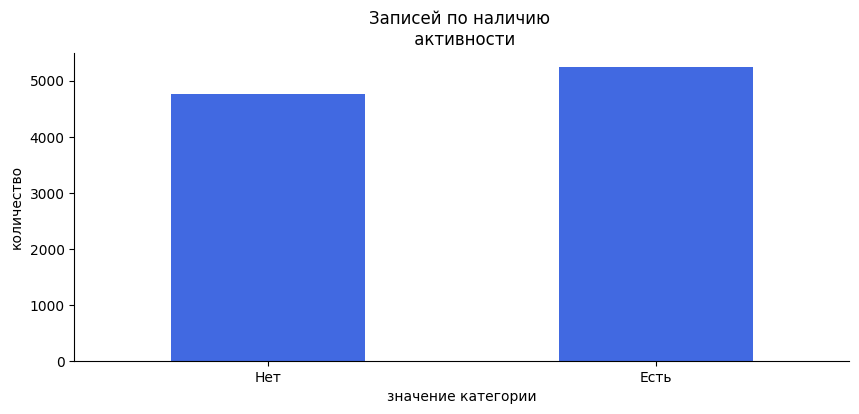

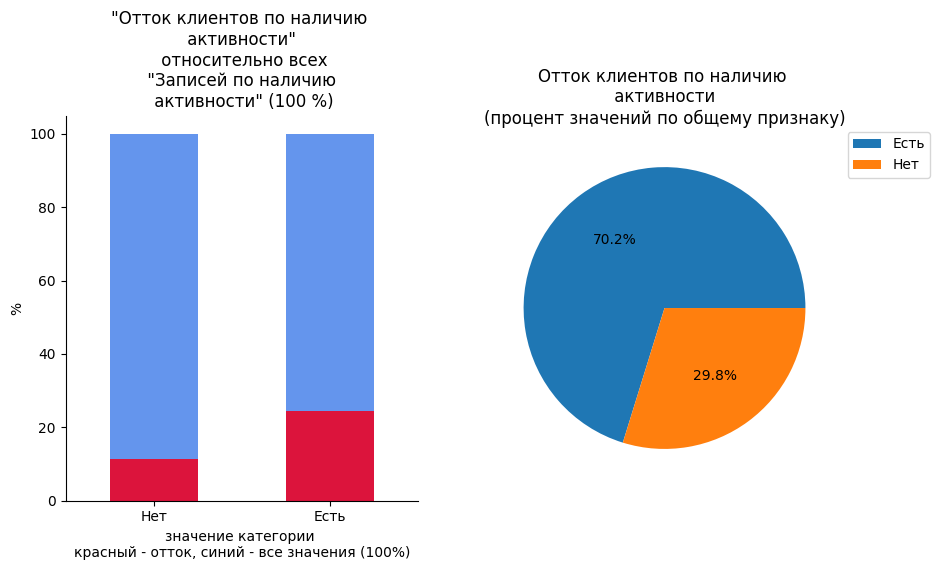

In [54]:
graf_char_index(data[data['churn'] == 1], 'last_activity', 'Отток клиентов по наличию \n активности', 
                data, True, 'Записей по наличию \n активности', 
                xlabel_sub_definition = 'красный - отток, синий - все значения (100%)',
               custom_labels100 = ['Нет', 'Есть'], main_labels = ['Нет', 'Есть'], custom_labels = ['Есть', 'Нет'])

Среди отточных больше активных клиентов - 70.2 % (против 29.8 % пассивных). Отток активных клиентов так же выше среди всех клиентов банка - 24 % (против 11 % среди пассивных).
- Больший отток у активных клиентов.

<a id="find_corr"></a>
#### [Корелляция](#description)
Построим матрицу корреляции по всем данным.

In [55]:
df_phik = data.copy(deep = True)

In [56]:
continuous_signs = ['age','score','balance','est_salary', ]
df_phik = df_phik.drop(columns = ['miss_balance',
                                  'sin_age',
                                 'sin_est_salary',
                                  'userid'])
phik_corr = df_phik.phik_matrix(interval_cols = continuous_signs)

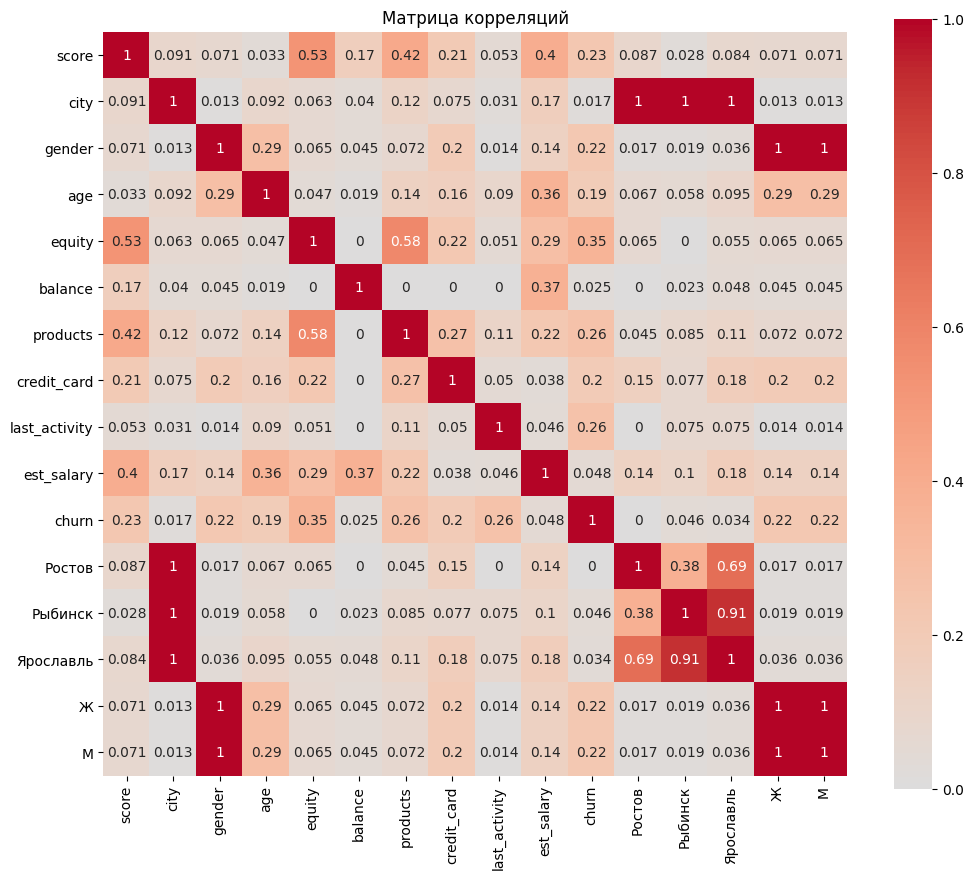

In [57]:
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(phik_corr, annot = True, cmap = 'coolwarm', center= 0, square=True, ax = ax)
ax.set_title('Матрица корреляций')
plt.show()

Построим отдельно по колонке оттока - churn.

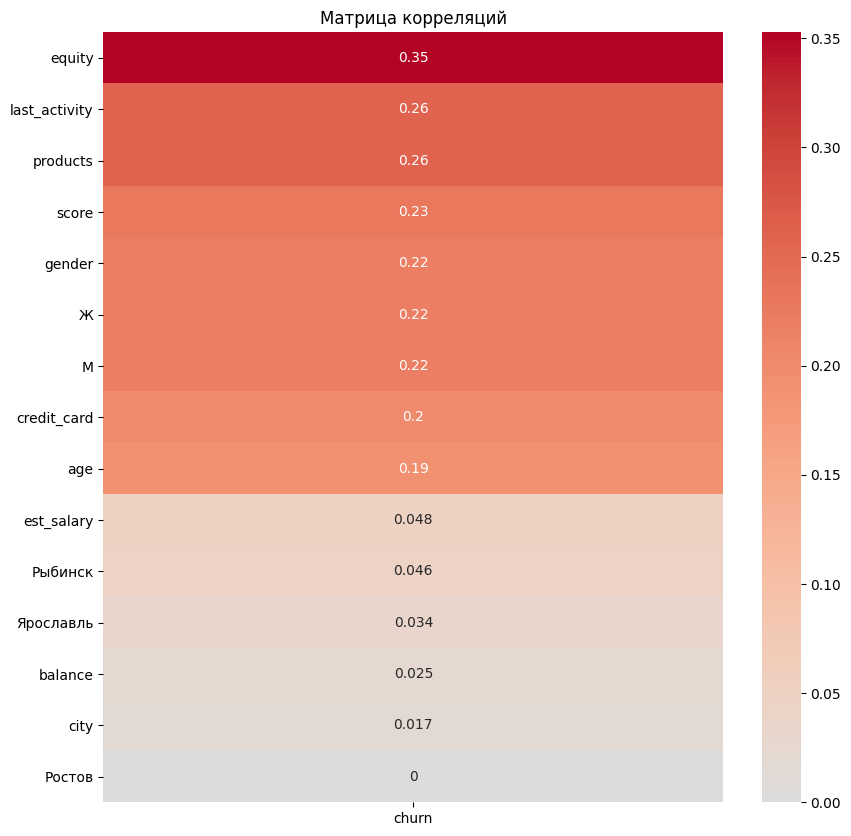

In [58]:
churn_corr = phik_corr.loc[:,['churn']].drop(index = ['churn']).sort_values(by = 'churn', ascending = False)
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(churn_corr, annot = True, cmap = 'coolwarm', center= 0, ax = ax)
ax.set_title('Матрица корреляций')
plt.show()

Отток больше всего коррелирует с ликвидностью собственности.

<a id="hypothesis"></a>
### [Статистические гипотезы](#description)

**Доход**

Проверим данные на нормальность для подбора статистического теста.

In [59]:
kstest(data['est_salary'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

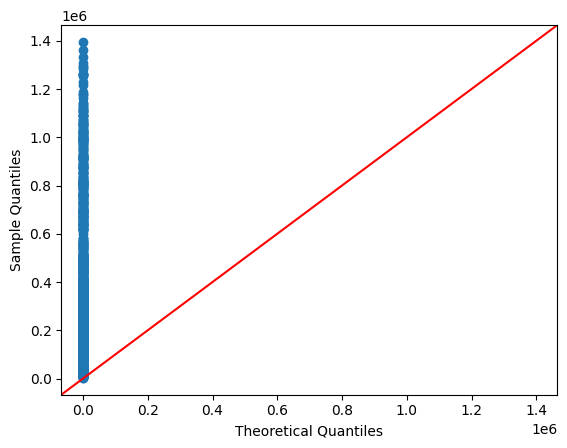

In [60]:
fig = sm.qqplot(data['est_salary'], line='45')
plt.show()

Доход - это непрерывная величина. Есть две группы - отточные клиенты и не отточные. Каждое наблюдение - независимо, то есть связи между ними нет. Распределение не является нормальным. Необходимо использовать непараметрический тест U-тест Манна-Уитни. 

- Н0 - доход отточных клиентов и не отточных не отличается.
- Н1 - он различен.

Критерий статистической значимости примем = 5 %.

In [61]:
alpha = 0.05
churn = data[data['churn']==1]['est_salary']
no_churn = data[data['churn']==0]['est_salary']

In [62]:
result = st.mannwhitneyu(no_churn, churn, nan_policy='omit')
print("p-value: {0:.3f}".format(result.pvalue))
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.000
Отвергаем нулевую гипотезу


Доход отточных и не отточных клиентов скорее различен. То есть наблюдение различий в доходах будет скорее закономерностью и статистически значимо, чем будет случайностью.

Так как имеються аномалии и распределение не является нормальным ttest Стюдента здесь не подходит и его результаты будут неверны.

    "В случае, когда в данных есть большие (по сравнению с нормальным распределением) выбросы, алгебраические метрики работают плохо. Да, они учитывают все значения. Но в этом также их слабое место: одно выбивающееся значение существенно влияет на результат."

In [63]:
results = st.ttest_ind(churn, no_churn)
    
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8987254468291451
Не получилось отвергнуть нулевую гипотезу


**Возраст**

- Н0 - возраст отточных клиентов и не отточных не отличается.
- Н1 - разный.

In [64]:
kstest(data['age'], 'norm')

KstestResult(statistic=nan, pvalue=nan)

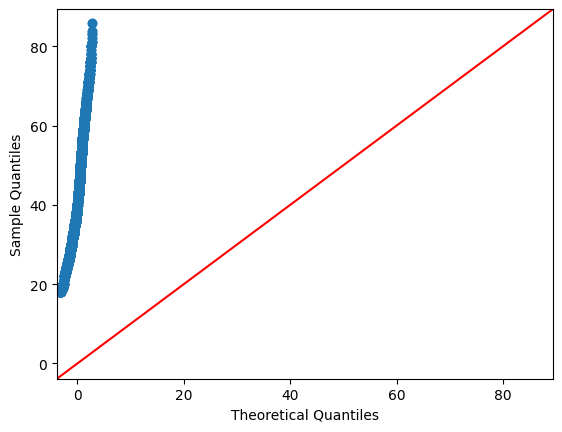

In [65]:
fig = sm.qqplot(data['age'], line='45')
plt.show()

In [66]:
churn = data[data['churn']==1]['age']
no_churn = data[data['churn']==0]['age']

In [67]:
result = st.mannwhitneyu(no_churn, churn, nan_policy = 'omit')
print("p-value: {0:.3f}".format(result.pvalue))
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.000
Отвергаем нулевую гипотезу


Возраст отточных и не отточных клиентов скорее одинаков. То есть наблюдение различий в возрасте будет скорее случайностью и статистически не значимо, чем будет закономерностью.

<a id="research_overview"></a>
### [Итоги исследования](#description)

**Обобщённый портрет не отточного клиента** <br>
Это обычно пассивный клиент женского пола около 40 лет, пользующися 2 продуктами банка, имеющий кредитную карту. Обычно с уровнем дохода в среднем 118257, оценкой ликвидности собственности 3, кредитным рейтингом около 848, и средним балансом на счёте 475382 (то есть примерно 4 средних дохода).

**Обобщённый портрет отточного клиента** <br>
Это обычно активный клиент мужского пола около 40 лет, пользующися 2 продуктами банка, имеющий кредитную карту. Обычно с уровнем дохода в среднем 125390, оценкой ликвидности собственности 4, кредитным рейтингом около 866, и средним балансом на счёте 782410 (то есть примерно 6 средних доходов).

Оба клиента обычно из Ярославля, но записей в целом из этого города больше всего.
У отточных доход немного выше. Но статистически он не различается.

**Отток**\
Наибольший отток клиентов (23.1 %) по score находится в диапазоне 825 - 925.
Диапазоны наибольшего оттока клиентов по возрасту: 25 - 35 лет (21.8 %) и 50 - 60 лет (26.5 %). В месте составляет 23.5 %.
При этом распределение не является нормальным и по непараметрическому тесту Манна-Уитни отточные и не отточные клиенты - разных возростов.
По balance наиболее отточными являются клиенты с балансом более 750 т. - 34.8 %.
В колонке est_salary множество выбросов, и распределение не является нормальным. Тест Манна-Уитни опроверг гипотезу об одинаковом доходе отточных и не отточных клиентов - доход различается. Отточных клиентов с доходом в итервале от 100 т. до 220 т. - 20.4 %.
Больше всего отточных клиентов в Ярославле - 61.4 % среди всех отточных. При этом уровень оттока относительно схож с Ростовом - 18 %.
Больше отточных клиентов мужского пола - как среди отточных (65 %), так и в целом среди всех клиентов - 24 %.
Наибольшее количество отточных клиентов имеют оценку собственности - 5 (31.7 %), 4 (25.5 %), 3 (17.7 %). При этом уровень отточности среди всех клиентов с такими оценками в диапазоне от 20 до 35 %. 

Наибольший отток клиентов с оценкой собственности 6,7,8 и 9, но количество самих клиентов небольшое - менее 100 для 7, 8, 9 и 161 для оценки 6. Для 5, 4, 3 количество всех клиентов в диапазоне от 1543 до 1918. Это массивные сегменты. 

По наличию кредитой карты количество отточных больше имеющих кредитную карту - 55.1 %. Но относительно всех клиентов уровень оттока больше у клиентов без неё. Больше отточных клиентов проявляющих активность - 70.2 %. Их уровень оттока так же выше среди всех клиентов по этому признаку - 24 %. Отток больше всего коррелирует с количеством использемых продуктов и оценкой собственности.

___
<a id="signatures"></a>
## [Формирование сегментов](#description)
На основе полученных признаков, комбинируя их - выявим группы сегментов с высоким оттоком.

In [68]:
category_columns = ['city', 'gender','products', 'credit_card', 'last_activity', 'equity']
continuous_columns = ['score', 'age', 'balance', 'est_salary']

In [69]:
def pie_plots5 (data, columns, subtitle =""):
    fig, ax = plt.subplots(2,2, figsize = (10,6))
    plt.suptitle(subtitle)
    for i, column in enumerate(columns[:-2]):
        bins = "{0:b}".format(i) # plot matrix - 2x2 only
        if len(bins) == 1:
            bins = '0' + bins
        first = int(bins[0])
        second = int(bins[1])
        data.loc[data['churn']==1, column].value_counts().plot(kind = 'pie', ax = ax[first, second], autopct='%1.1f%%',
                                                         title = f'{column}',
                                                         ylabel = '')
    fig, axs = plt.subplots(1,2,figsize = (8,4))
    data.loc[data['churn']==1, columns[-2]].value_counts().plot(kind = 'pie', ax = axs[0], autopct='%1.1f%%',
                                                         title = f'{category_columns[-2]}',
                                                         ylabel = '')
    data.loc[data['churn']==1, columns[-1]].value_counts().plot(kind = 'pie', ax = axs[1], autopct='%1.1f%%',
                                                         title = f'{category_columns[-1]}',
                                                         ylabel = '')
    plt.show()

In [70]:
def continuous_plots (data, columns, subtitle =""):
    fig, ax = plt.subplots(2,2, figsize = (10,6))
    plt.suptitle(subtitle)
    plt.subplots_adjust(hspace=0.5)
    for i, column in enumerate(columns):
        bins = "{0:b}".format(i) # plot matrix - 2x2 only
        if len(bins) == 1:
            bins = '0' + bins
        first = int(bins[0])
        second = int(bins[1])
        data.loc[data['churn']==1, column].hist(ax = ax[first,second], grid = False, color = '#008080',edgecolor = "silver")
        ax[first,second].set_title(f'Распределение по {column}')
        ax[first,second].set_ylabel('частота появления')
        ax[first,second].set_xlabel('значение')
    plt.show()

Отберём сегменты, построим их портерты и посмотрим сегмент детальнее.

In [71]:
one = data.query('(equity == 5) and (last_activity == 1) and (credit_card == 0)')
portrait(one)

churn,sing,parameter,no_churn,yes_churn
0,age,mean,47.386047,41.801724
14,age,mean_diff_pct,13.359072,-11.78474
1,age,median,46.0,39.5
15,age,median_diff_pct,16.455696,-14.130435
2,balance,mean,1355434.789349,1428799.288412
16,balance,mean_diff_pct,-5.134696,5.412617
3,balance,median,830754.69,1109991.89
17,balance,median_diff_pct,-25.156688,33.612473
13,city,,Ярославль,Ярославль
11,credit_card,,0.0,0.0


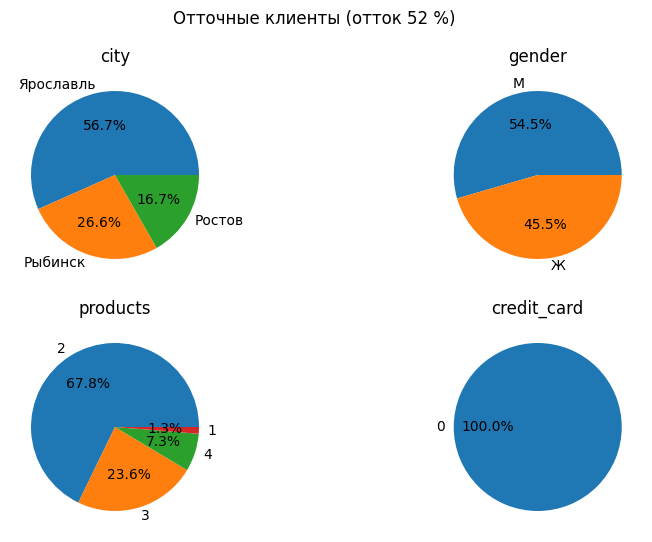

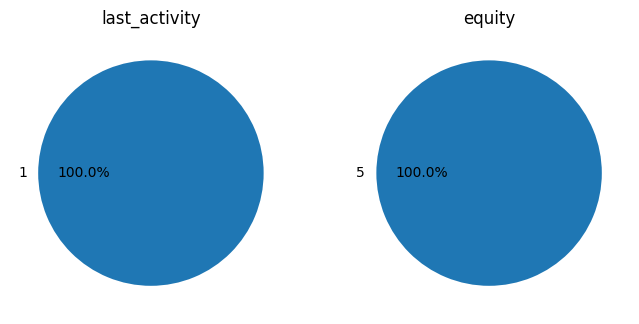

In [72]:
pie_plots5(one, category_columns, 'Отточные клиенты (отток 52 %)')

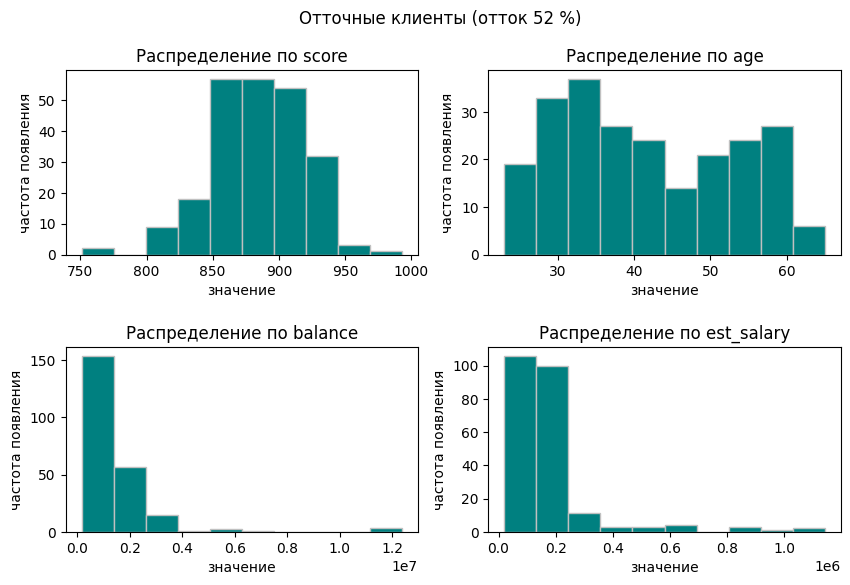

In [73]:
continuous_plots (one, continuous_columns, 'Отточные клиенты (отток 52 %)')

In [74]:
min_max_values(one[continuous_columns])

В колонке score минимальное значение - 724.0, максимальное значение - 1000.0.
В колонке age минимальное значение - 23.0, максимальное значение - 76.0.
В колонке balance минимальное значение - 99885.68, максимальное значение - 43277099.84.
В колонке est_salary минимальное значение - 9766.13, максимальное значение - 1142435.95.


**Сегмент с оттоком 52 %.** Сегмент 448 клиентов. Отточных - 233, не отточных - 215. 

Обобщённый портерт отточного клиента: <br>
Мужчина 39 - 42 года пользующийся в среднем 2 продуктами банка, проявляющий активность. Не имеет кредитной карты. Со средней ликвидностью собственности (5), с доходом в среднем 138 т., балансом обычно около 1.1 млн. и рейтингом 885.

Дополнительные сведенья об отточных клиентах в сегменте: <br>
В этом сегменте мужчин - 54.5 %, женщин - 45.5 %. Чаще из Ярославля - 56.7 %. Из Рыбинска - 23.6 %, из Ростова - 16.7 %. У всех нет кредитной карты. Все проявляют активность. Чаще в сегменте клиенты с рейтингом в диапазоне 724 - 1000 (больше - к центру диапазона), разных возростов (от 23 до 60, старше - немного), с балансом обычно до 2.5 млн. (чаще - значительно ниже) и доходом до 220 т. - чаще ниже, выше - очень мало. Двумя продуктами пользуются - 67.8 %, тремя - 23.6 %, четерымя - 7.3 %, одним - 1.3 %.

Этим клиентам можно предложить кредитную карту, кредит, автокредит, стархование.

In [75]:
two = data.query('(750000 < balance) and (25 <= age <= 35)')
portrait(two)

churn,sing,parameter,no_churn,yes_churn
0,age,mean,32.507788,31.831683
14,age,mean_diff_pct,2.124,-2.079825
1,age,median,33.0,32.0
15,age,median_diff_pct,3.125,-3.030303
2,balance,mean,1538681.722804,1707912.127525
16,balance,mean_diff_pct,-9.908613,10.998402
3,balance,median,1047739.52,1236082.35
17,balance,median_diff_pct,-15.237078,17.976112
13,city,,Ярославль,Ярославль
11,credit_card,,1.0,0.0


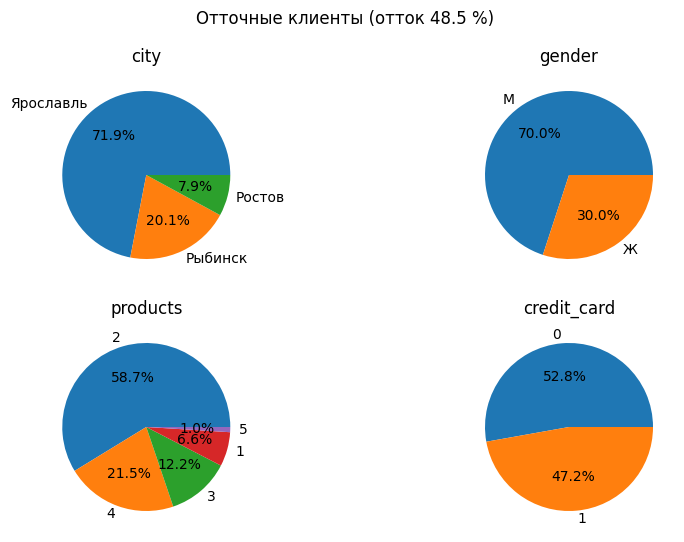

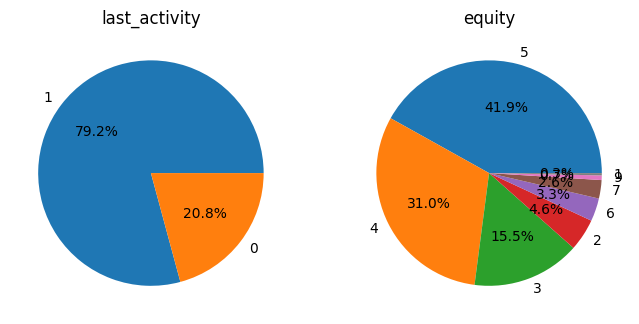

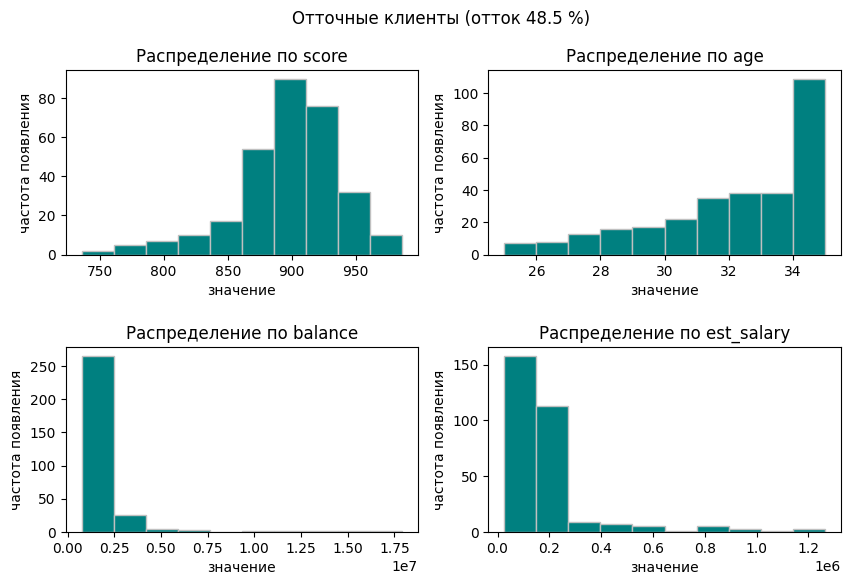

В колонке score минимальное значение - 736.0, максимальное значение - 1000.0.
В колонке age минимальное значение - 25.0, максимальное значение - 35.0.
В колонке balance минимальное значение - 750116.48, максимальное значение - 21549943.63.
В колонке est_salary минимальное значение - 23563.19, максимальное значение - 1395064.45.


In [76]:
pie_plots5(two, category_columns, 'Отточные клиенты (отток 48.5 %)')
continuous_plots (two, continuous_columns, 'Отточные клиенты (отток 48.5 %)')
min_max_values(two[continuous_columns])

**Сегмент с оттоком 48.5 %.** Сегмент 624 клиента. Отточных - 303, не отточных - 321. 

Обобщённый портерт отточного клиента: <br>
обычно мужчина 32 года, активный, пользующийся двумя продуктами банка. Не имеющий кредитной катры, имеющий рейтинг около 900. С доходом в среднем 150 т. и балансом около 1.5 млн. и ликвидность собственности равной 4.

Дополнительные сведенья об отточных клиентах в сегменте: <br>
В сегменте отточные клиенты обычно из Ярославля - 71.9 % клиентов. Из Рыбинска - 20.1 %, из Ростова - 7.9 %. Клиенты в сегменте приимущественно мужского пола - 70 %. Двумя продуктами пользуются 58.7 % отточных клиентов, 4 - 21.5 %, 3 - 12.2 %, 1 - 6.6 %, а пятью - 1 %. То есть чаще 2 продукта и менее часто 4, остальные - реже. Кредитной карты нет у чуть больше половины из отточных - 52.8 %. Чаще это активные клиенты (проявляют активность) - 79.2 %. Рейтинг в диапазоне 736 - 1000, но чаще в пределах 850 - 950. Возраст от 25 до 35, при этом чаще в диапазоне от 30 до 35. Значение баланса обычно до 2.5 млн. - чаще меньше. Доход отточных клиентов обычно до 300 т. и чаще ниже. 

Этим клиентам можно предложить ипотеку, кредит, автокредит и кредитную карту.

In [77]:
three = data.query('(750000 < balance < 4000000) and (sin_est_salary == 1) and (825 < score < 925)')
portrait(three)

churn,sing,parameter,no_churn,yes_churn
0,age,mean,44.45648,41.751756
14,age,mean_diff_pct,6.478107,-6.08398
1,age,median,43.0,39.0
15,age,median_diff_pct,10.25641,-9.302326
2,balance,mean,1221505.332259,1416679.249649
16,balance,mean_diff_pct,-13.77686,15.978147
3,balance,median,1120523.81,1294391.76
17,balance,median_diff_pct,-13.432406,15.516667
13,city,,Ярославль,Ярославль
11,credit_card,,1.0,0.0


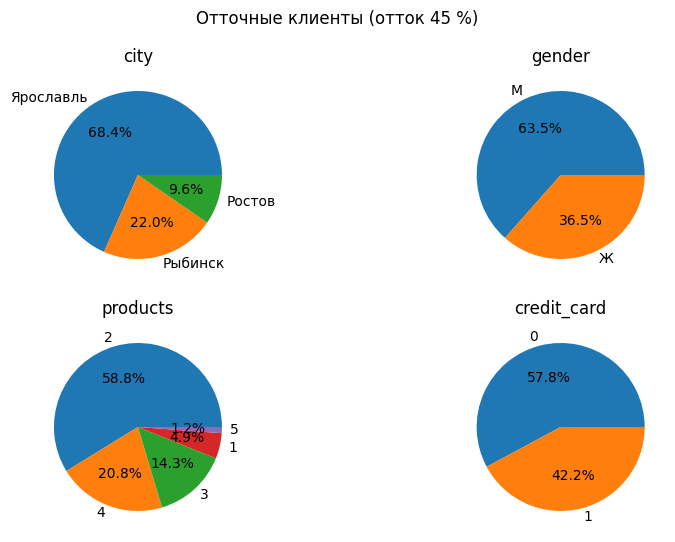

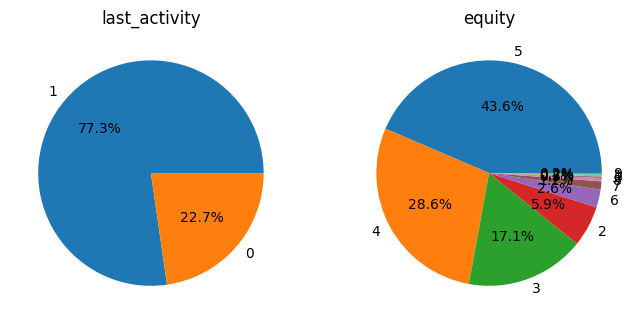

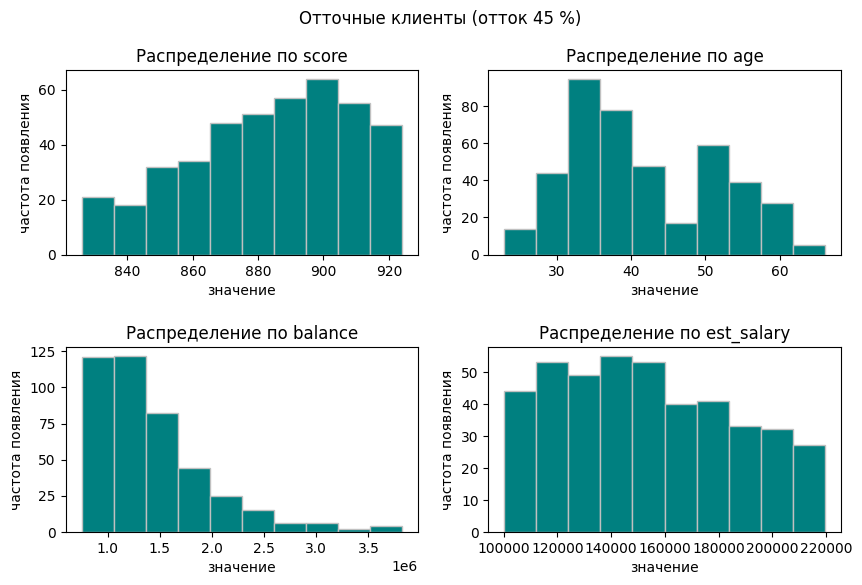

В колонке score минимальное значение - 826.0, максимальное значение - 924.0.
В колонке age минимальное значение - 23.0, максимальное значение - 80.0.
В колонке balance минимальное значение - 750097.33, максимальное значение - 3821282.25.
В колонке est_salary минимальное значение - 100104.42, максимальное значение - 219976.58.


In [78]:
pie_plots5(three, category_columns, 'Отточные клиенты (отток 45 %)')
continuous_plots (three, continuous_columns, 'Отточные клиенты (отток 45 %)')
min_max_values(three[continuous_columns])

**Сегмент - 45 %.** Сегмент 945 клиентов. Отточных - 427, не отточных - 518. 

Обобщённый портерт отточного клиента: <br>
Обычно мужчина возраста 39 - 42, активный, пользующийся 2 продуктами банка. С ликвидностью собственности 4, доходом 150 т., балансом обычно 1.3 млн., рейтингом около 887 и обычно без кредитной карты.

Дополнительные сведенья об отточных клиентах в сегменте:
В сегменте отточные клиенты обычно из Ярославля - 68.4 % клиентов. Из Рыбинска - 22 %, из Ростова - 9.6 %. Клиенты в сегменте приимущественно мужского пола - 63.5 %. Кредитной карты нет у 57.8 %. Чаще это активные клиенты (проявляют активность) - 77.3 %. Рейтинг в диапазоне 826 - 924. Возраст от 23 до 60, чаще от 28 до 45 и от 50 до 60 (клиентов старше 60 - очень мало). Значение баланса обычно до 2.2 млн. - чаще меньше, максимум - 3.8 млн.. Доход отточных клиентов обычно в диапазоне от 100 т. до 220 т.. Двумя продуктами пользуются - 58.8 %, четерымя - 20.8 %, тремя - 14.3 %, одним - 4.9 %, пятью (максимум) - 1.2 %. Ликвидность собственности обычно средняя (5) - 43.6 %, четыре - у 28.6 %, три у 17.1 %, остальное - редко.

Этим клиентам можно предложить кредитную карту, кредит, автокредит, страхование, инвестиции.

In [79]:
four = data.query('(850 < score < 925) and (25 <= age <= 35) and (last_activity == 1)')
portrait(four)

churn,sing,parameter,no_churn,yes_churn
0,age,mean,30.966759,30.583815
14,age,mean_diff_pct,1.252113,-1.236629
1,age,median,31.0,31.0
15,age,median_diff_pct,0.0,0.0
2,balance,mean,660523.1522,861506.426301
16,balance,mean_diff_pct,-23.329283,30.427892
3,balance,median,447394.155,730829.27
17,balance,median_diff_pct,-38.782671,63.35244
13,city,,Ярославль,Ярославль
11,credit_card,,1.0,1.0


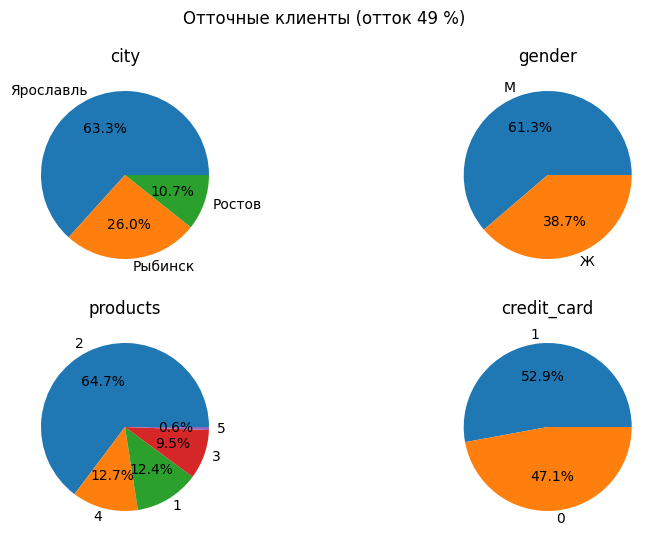

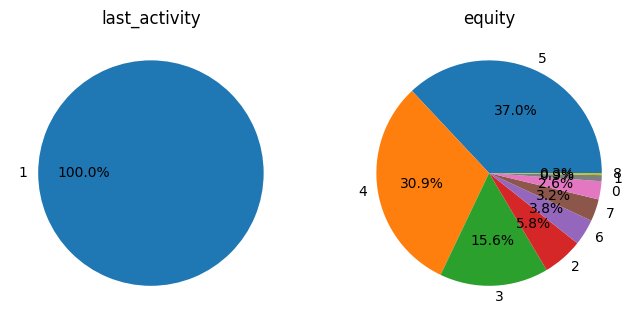

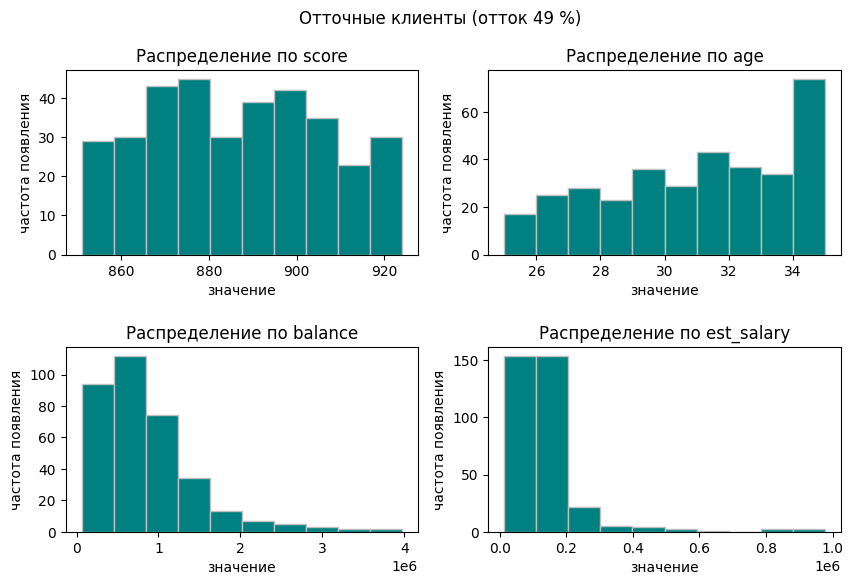

В колонке score минимальное значение - 851.0, максимальное значение - 924.0.
В колонке age минимальное значение - 25.0, максимальное значение - 35.0.
В колонке balance минимальное значение - 46257.41, максимальное значение - 15624095.8.
В колонке est_salary минимальное значение - 13616.26, максимальное значение - 1395064.45.


In [80]:
pie_plots5(four, category_columns, 'Отточные клиенты (отток 49 %)')
continuous_plots (four, continuous_columns, 'Отточные клиенты (отток 49 %)')
min_max_values(four[continuous_columns])

**Сегмент с оттоком 49 %.** Сегмент 707 клиентов. Отточных - 346, не отточных - 361. 

Обобщённый портерт отточного клиента: <br>
Обычно мужчина возраста 31, активный, пользующийся 2 продуктами банка. С ликвидностью собственности 4, доходом около 120 т., балансом обычно 730 т., рейтингом обычно 886 и имеющий кредитную карту.

Дополнительные сведенья об отточных клиентах в сегменте: <br>
В сегменте отточные клиенты обычно из Ярославля - 63.3 % клиентов. Из Рыбинска - 26 %, из Ростова - 10.7 %. Клиенты в сегменте приимущественно мужского пола - 61.3 %. Кредитной карта есть у - 52.9 % (немного больше половины среди отточных клиентов). Рейтинг в диапазоне 851 - 924, но в целом достаточно равномерно распределён. Возраст от 25 до 35. Значение баланса обычно до 1.5 млн. - чаще меньше. Доход отточных клиентов обычно до 200 т. - чаще ниже.

Эти клиентам можно предложить ипотеку, инвестиции, кредит, вклад.

Сравним сегменты по отточности.

In [81]:
comparison = pd.DataFrame(columns = ['churn_pct','churn_clients', 'size'])
for i, dn in enumerate([one, two, three, four], start = 1):
    x = dn.agg({'churn':['mean','sum','count']})
    comparison.loc[f'{i} segment', ['churn_pct','churn_clients', 'size']] = [round(x.loc[['mean'],'churn'][0]*100,2),
                                                                             x.loc[['sum'],'churn'][0],
                                                                             x.loc[['count'],'churn'][0]]

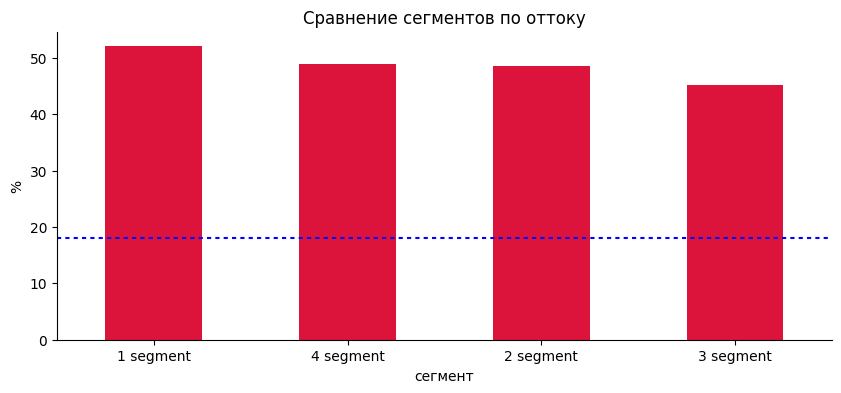

In [82]:
figure, ax = plt.subplots(figsize = (10,4))
plt.subplots_adjust(hspace=0.5)
x = comparison.sort_values(by = 'churn_pct', ascending = False)
x['churn_pct'].plot(kind = 'bar', color = '#DC143C', rot = 0,
                    title = 'Сравнение сегментов по оттоку',
                    xlabel = 'сегмент', ylabel = '%', ax = ax)
ax.axhline(18, color="b", dashes=(2, 2))
sns.despine() 
plt.show()

Сегмент 1 самый отточный - 52 % оттока. Его стоит взять в первую очередь. В сегменте 4 отток - 49 %. Он на втором месте по значимости. Во втором сегменте отток - 48.5 %, он третий по приоритету. В третьем сегменте отток - 45 %. Он последний в приоритете. 

Итого приоритеты в порядке убывания: 1 сегмент, 4 сегмент, 2 сегмент, 3 сегмент.

Пометим приоритеты, сегменты и посмотрим количество отточных клиентов в каждом сегменте, а так же какой они охватывают процент отточных клиентов от всего оттока. Так же посмотрим, сколько их в датафрейме.

In [83]:
two_churn = two.loc[two['churn']==1].index
four_churn = four.loc[four['churn']==1].index
one_churn = one.loc[one['churn']==1].index
three_churn = three.loc[three['churn']==1].index

In [84]:
size = pd.DataFrame(index = range(3), columns = ['segment','size'])
segments_list = ['1 segment', '2 segment', '3 segment', '4 segment']
for i, sz in enumerate([one, two, three, four]):
    size.loc[i, ['segment','size']] = [segments_list[i], len(sz)]

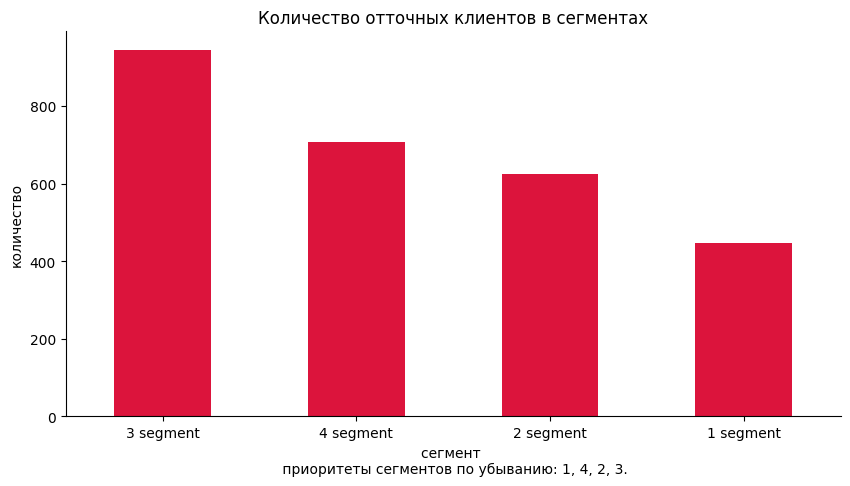

In [85]:
size = size.sort_values(by = 'size', ascending = False)
figure, ax = plt.subplots(figsize = (10,5))
size.plot(kind = 'bar', color = '#DC143C', rot = 0,
                    title = 'Количество отточных клиентов в сегментах',
                    xlabel = 'сегмент \n приоритеты сегментов по убыванию: 1, 4, 2, 3.', 
                    ylabel = 'количество', ax = ax)
labels = size['segment'].to_list()
ax.set_xticklabels(labels)
ax.legend().remove()
sns.despine() 
plt.show()

Размеры сегментов: 1 – 448 клиентов, 2 – 624, 3 – 945, 4 – 707.

In [86]:
segments_list = ['1 segment', '4 segment', '2 segment', '3 segment']
priority = [4,3,2,1]
for i, idx in enumerate([three_churn, two_churn, four_churn, one_churn]):
    data.loc[idx,['priority', 'segment']] = [priority[i], segments_list[i]]

In [87]:
print('Процент сегментированных среди всех отточных клиентов:',
      round(data.loc[data['priority'].isna() == False].shape[0]/data['churn'].sum()*100), '%')
print(f'Всего отточных клиентов в сегментах: {data.loc[data["priority"].isna() == False].shape[0]}')

Процент сегментированных среди всех отточных клиентов: 47 %
Всего отточных клиентов в сегментах: 851


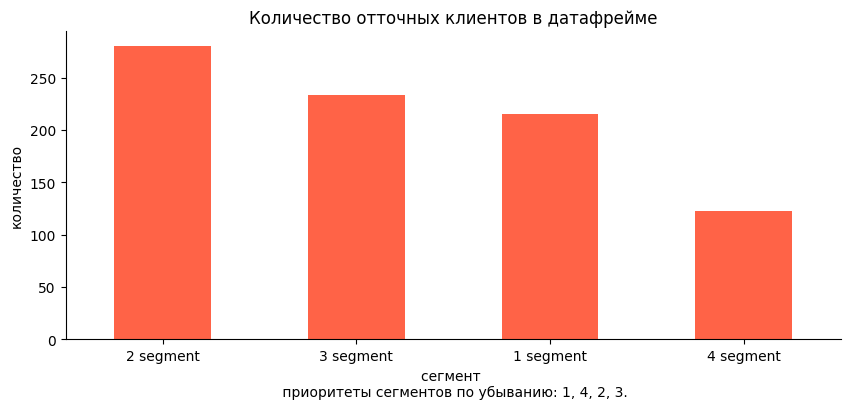

In [88]:
data['segment'].value_counts().plot(kind = 'bar', color = '#FF6347', rot = 0,
                    title = 'Количество отточных клиентов в датафрейме',
                    xlabel = 'сегмент \n приоритеты сегментов по убыванию: 1, 4, 2, 3.', 
                    ylabel = 'количество', figsize = (10,4))
sns.despine() 
plt.show()

In [89]:
data['segment'].value_counts()

2 segment    280
3 segment    233
1 segment    215
4 segment    123
Name: segment, dtype: int64

В третьем сегменте 233 клиентов (отток 48 %). В четвёртом сегменте 175 клиент (отток - 45 %). В первом - 215 клиентов, это самый отточный сегмент - 52 %. Во втором сегменте 280 клиент, а уровень оттока - 48.5 %. 

Охват среди отточных клиентов в датасете - 47 % (851 клиента).

___
<a id="оverall_conclusion"></a>
## [Итоги проекта](#description)

**Обобщённый портрет не отточного клиента:** <br>
        
Это обычно пассивный клиент женского пола около 40 лет, пользующися 2 продуктами банка, имеющий кредитную карту. Обычно с уровнем дохода в среднем 118257, оценкой ликвидности собственности 3, кредитным рейтингом около 848, и средним балансом на счёте 475382 (то есть примерно 4 средних дохода).

**Обобщённый портрет отточного клиента:** <br>
Это обычно активный клиент мужского пола около 40 лет, пользующися 2 продуктами банка, имеющий кредитную карту. Обычно с уровнем дохода в среднем 125390, оценкой ликвидности собственности 4, кредитным рейтингом около 866, и средним балансом на счёте 782410 (то есть примерно 6 средних доходов).

Оба клиента обычно из Ярославля, но записей в целом из этого города больше всего.
У отточных доход немного выше. Но статистически он не различается.

**Исследование.**<br>
Наибольший отток клиентов (23.1 %) по score находится в диапазоне 825 - 925.
Диапазоны наибольшего оттока клиентов по возрасту: 25 - 35 лет (21.8 %) и 50 - 60 лет (26.5 %). Вместе составляет 23.5 %.
При этом распределение не является нормальным и по непараметрическому тесту Манна-Уитни отточные и не отточные клиенты - разных возростов.
По balance наиболее отточными являются клиенты с балансом более 750 т. - 34.8 %.
В колонке est_salary множество выбросов, и распределение не является нормальным. Тест Манна-Уитни опроверг гипотезу об одинаковом доходе отточных и не отточных клиентов - доход различается. Отточных клиентов с доходом в итервале от 100 т. до 220 т. - 20.4 %.
Больше всего отточных клиентов в Ярославле - 61.4 % среди всех отточных. При этом уровень оттока относительно схож с Ростовом - 18 %.
Больше отточных клиентов мужского пола - как среди отточных (65 %), так и в целом среди всех клиентов - 24 %.
Наибольшее количество отточных клиентов имеют оценку собственности - 5 (31.7 %), 4 (25.5 %), 3 (17.7 %). При этом уровень отточности среди всех клиентов с такими оценками в диапазоне от 20 до 35 %. 

Наибольший отток клиентов с оценкой собственности 6,7,8 и 9, но количество самих клиентов небольшое - менее 100 для 7, 8, 9 и 161 для оценки 6. Для 5, 4, 3 количество всех клиентов в диапазоне от 1543 до 1918. Это массивные сегменты. 

По наличию кредитой карты количество отточных больше имеющих кредитную карту - 55.1 %. Но относительно всех клиентов уровень оттока больше у клиентов без неё. Больше отточных клиентов проявляющих активность - 70.2 %. Их уровень оттока так же выше среди всех клиентов по этому признаку - 24 %. Отток больше всего коррелирует с количеством использемых продуктов и оценкой собственности.

**Сегменты.**<br>
В результате исследования было выявлено 4 сегмента с оттоком выше среднего оттока по банку мнимум в 2 раза.
Сегмент 1 самый отточный - 52 % оттока. Его стоит взять в первую очередь. В сегменте 4 отток - 49 %. Он на втором месте по значимости. Во втором сегменте отток - 48.5 %, он третий по приоритету. В третьем сегменте отток - 45 %. Он последний в приоритете.

Приоритет сегментов: по проценту оттока. Итого приоритеты в порядке убывания: 1 сегмент, 4 сегмент, 2 сегмент, 3 сегмент.

**Сегмент с оттоком 52 %.** <br>
Сегмент 448 клиентов. Отточных - 233, не отточных - 215. 215 отточных клиента по этому сегменту в датафрейме.

Обобщённый портерт отточного клиента: <br>
Мужчина 39 - 42 года пользующийся в среднем 2 продуктами банка, проявляющий активность. Не имеет кредитной карты. Со средней ликвидностью собственности (5), с доходом в среднем 138 т., балансом обычно около 1.1 млн. и рейтингом 885.

Дополнительные сведенья об отточных клиентах в сегменте: <br>
В этом сегменте мужчин - 54.5 %, женщин - 45.5 %. Чаще из Ярославля - 56.7 %. Из Рыбинска - 23.6 %, из Ростова - 16.7 %. У всех нет кредитной карты. Все проявляют активность. Чаще в сегменте клиенты с рейтингом в диапазоне 724 - 1000 (больше - к центру диапазона), разных возростов (от 23 до 60, старше - немного), с балансом обычно до 2.5 млн. (чаще - значительно ниже) и доходом до 220 т. - чаще ниже, выше - очень мало. Двумя продуктами пользуются - 67.8 %, тремя - 23.6 %, четерымя - 7.3 %, одним - 1.3 %.

Этим клиентам можно предложить кредитную карту, кредит, автокредит, стархование.

**Сегмент с оттоком 49 %.** <br>
Сегмент 707 клиентов. Отточных - 346, не отточных - 361. 175 отточных клиентов в датафрейме.

Обобщённый портерт отточного клиента: <br>
Обычно мужчина возраста 31, активный, пользующийся 2 продуктами банка. С ликвидностью собственности 4, доходом около 120 т., балансом обычно 730 т., рейтингом обычно 886 и имеющий кредитную карту.

Дополнительные сведенья об отточных клиентах в сегменте: <br>
В сегменте отточные клиенты обычно из Ярославля - 63.3 % клиентов. Из Рыбинска - 26 %, из Ростова - 10.7 %. Клиенты в сегменте приимущественно мужского пола - 61.3 %. Кредитной карта есть у - 52.9 % (немного больше половины среди отточных клиентов). Рейтинг в диапазоне 851 - 924, но в целом достаточно равномерно распределён. Возраст от 25 до 35. Значение баланса обычно до 1.5 млн. - чаще меньше. Доход отточных клиентов обычно до 200 т. - чаще ниже.

Эти клиентам можно предложить ипотеку, инвестиции, кредит, вклад.

**Сегмент с оттоком 48.5 %.** <br>
Сегмент 624 клиента. Отточных - 303, не отточных - 321. 280 отточный клиент в датафрейме.

Обобщённый портерт отточного клиента: <br>
обычно мужчина 32 года, активный, пользующийся двумя продуктами банка. Не имеющий кредитной катры, имеющий рейтинг около 900. С доходом в среднем 150 т. и балансом около 1.5 млн. и ликвидность собственности равной 4.

Дополнительные сведенья об отточных клиентах в сегменте: <br>
В сегменте отточные клиенты обычно из Ярославля - 71.9 % клиентов. Из Рыбинска - 20.1 %, из Ростова - 7.9 %. Клиенты в сегменте приимущественно мужского пола - 70 %. Двумя продуктами пользуются 58.7 % отточных клиентов, 4 - 21.5 %, 3 - 12.2 %, 1 - 6.6 %, а пятью - 1 %. То есть чаще 2 продукта и менее часто 4, остальные - реже. Кредитной карты нет у чуть больше половины из отточных - 52.8 %. Чаще это активные клиенты (проявляют активность) - 79.2 %. Рейтинг в диапазоне 736 - 1000, но чаще в пределах 850 - 950. Возраст от 25 до 35, при этом чаще в диапазоне от 30 до 35. Значение баланса обычно до 2.5 млн. - чаще меньше. Доход отточных клиентов обычно до 300 т. и чаще ниже. 

Этим клиентам можно предложить ипотеку, кредит, автокредит и кредитную карту.

**Сегмент - 45 %.** Сегмент 945 клиентов. Отточных - 427, не отточных - 518. 233 отточных клиента в датасете.

Обобщённый портерт отточного клиента: <br>
Обычно мужчина возраста 39 - 42, активный, пользующийся 2 продуктами банка. С ликвидностью собственности 4, доходом 150 т., балансом обычно 1.3 млн., рейтингом около 887 и обычно без кредитной карты.

Дополнительные сведенья об отточных клиентах в сегменте:
В сегменте отточные клиенты обычно из Ярославля - 68.4 % клиентов. Из Рыбинска - 22 %, из Ростова - 9.6 %. Клиенты в сегменте приимущественно мужского пола - 63.5 %. Кредитной карты нет у 57.8 %. Чаще это активные клиенты (проявляют активность) - 77.3 %. Рейтинг в диапазоне 826 - 924. Возраст от 23 до 60, чаще от 28 до 45 и от 50 до 60 (клиентов старше 60 - очень мало). Значение баланса обычно до 2.2 млн. - чаще меньше, максимум - 3.8 млн.. Доход отточных клиентов обычно в диапазоне от 100 т. до 220 т.. Двумя продуктами пользуются - 58.8 %, четерымя - 20.8 %, тремя - 14.3 %, одним - 4.9 %, пятью (максимум) - 1.2 %. Ликвидность собственности обычно средняя (5) - 43.6 %, четыре - у 28.6 %, три у 17.1 %, остальное - редко.

Этим клиентам можно предложить кредитную карту, кредит, автокредит, страхование, инвестиции.
___
*Отметки в датафрейме.*

*В третьем сегменте 233 клиентов (отток 45 %). В четвёртом сегменте 175 клиент (отток - 49 %). В первом - 215 клиентов, это самый отточный сегмент - 52 %. Во втором сегменте 280 клиент, а уровень оттока - 48.5 %.*

*Процент сегментированных среди всех отточных клиентов (охват в датафрейме среди отточных): 47 %.
Всего отточных клиентов в сегментах: 851.*

___
[🡅🡅🡅](#top)